# Exploratory Data Analysis for FARS

The Fatality Analysis Reporting System (FARS) contains a wide variety of records on factors that were present during traffic fatalities in the United States. This system is part of the National Highway Traffic Safety Administration (NHTSA)

# Table of Contents
1. [Research Questions](#id0)
2. [Import Packages](#id1)
3. [Load the Data](#id2)
4. [Cleaning Out Nan Values and Adding Variables](#id3)
5. [Dividing into Urban and Rural Datasets](#id4)
6. [Initial Exploration](#id5)
7. [General Conclusions](#id6)
8. [Saving the Data](#id7)

<a id="id0"></a>

## Research Questions

In considering the transformation of rural areas into nonrural areas in the US, what factors most strongly predict fatal crashes in each context for the year under consideration and thereby what is predictable as this transformation continues? Will there be more fatal crashes if rural areas are transformed to urban areas? Do rural and urban areas have the same factors that correlate with fatalities.


<a id="id1"></a>

## Import packages

In [93]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import ppscore as pps
import warnings
warnings.filterwarnings('ignore')

<a id="id2"></a>

## Load the Data

In [94]:
total = pd.read_csv('../data/processed/accident.csv')

In [95]:
total.head(3)

,STATENAME,VE_TOTAL,PEDS,PERSONS,DAYNAME,MONTHNAME,HOUR,DAY_WEEKNAME,RUR_URBNAME,HARM_EVNAME,LGT_CONDNAME,WEATHER1NAME,WEATHERNAME,FATALS,DRUNK_DR
0,Alabama,2,0,3,7,February,12,Thursday,Urban,Motor Vehicle In-Transport,Daylight,Clear,Clear,1,1
1,Alabama,2,0,2,23,January,18,Wednesday,Urban,Motor Vehicle In-Transport,Dark - Not Lighted,Rain,Rain,1,0
2,Alabama,3,0,4,22,January,19,Tuesday,Rural,Motor Vehicle In-Transport,Dark - Not Lighted,Cloudy,Cloudy,1,0


In [96]:
total.describe().T

,count,mean,std,min,25%,50%,75%,max
VE_TOTAL,33482.0,1.578400,0.803183,1.0,1.0,1.0,2.0,16.0
PEDS,33482.0,0.234305,0.473574,0.0,0.0,0.0,0.0,9.0
PERSONS,33482.0,2.234872,1.683039,0.0,1.0,2.0,3.0,57.0
DAYNAME,33482.0,15.696464,8.836329,1.0,8.0,16.0,23.0,31.0
HOUR,33482.0,13.564064,10.022199,0.0,7.0,14.0,19.0,99.0
FATALS,33482.0,1.085538,0.344911,1.0,1.0,1.0,1.0,8.0
DRUNK_DR,33482.0,0.265934,0.459075,0.0,0.0,0.0,1.0,4.0


In [97]:
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33482 entries, 0 to 33481
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   STATENAME     33482 non-null  object
 1   VE_TOTAL      33482 non-null  int64 
 2   PEDS          33482 non-null  int64 
 3   PERSONS       33482 non-null  int64 
 4   DAYNAME       33482 non-null  int64 
 5   MONTHNAME     33482 non-null  object
 6   HOUR          33482 non-null  int64 
 7   DAY_WEEKNAME  33482 non-null  object
 8   RUR_URBNAME   33482 non-null  object
 9   HARM_EVNAME   33482 non-null  object
 10  LGT_CONDNAME  33482 non-null  object
 11  WEATHER1NAME  33482 non-null  object
 12  WEATHERNAME   33482 non-null  object
 13  FATALS        33482 non-null  int64 
 14  DRUNK_DR      33482 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.8+ MB


In [98]:
sum=total.FATALS.sum()
sum

36346

In [99]:
rare=total[total.FATALS == 8]
rare

,STATENAME,VE_TOTAL,PEDS,PERSONS,DAYNAME,MONTHNAME,HOUR,DAY_WEEKNAME,RUR_URBNAME,HARM_EVNAME,LGT_CONDNAME,WEATHER1NAME,WEATHERNAME,FATALS,DRUNK_DR
17429,Mississippi,2,0,10,3,June,3,Monday,Rural,Motor Vehicle In-Transport,Dark - Not Lighted,Clear,Clear,8,0


<a id="id3"></a>

### Cleaning Out Nan Values and Making New Columns

In [100]:
total.dropna(inplace = True)

In [101]:
total['DAY_WEEKNAME'].value_counts()

Saturday     5646
Friday       5293
Sunday       5128
Thursday     4467
Monday       4374
Tuesday      4314
Wednesday    4260
Name: DAY_WEEKNAME, dtype: int64

In [102]:
### Dropping unknowns designated as 99
total = total[total.HOUR != 99]

In [103]:
###Maing Regions from state names
total.STATENAME.unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [104]:
 regions = {
    'Alabama': 'South',
    'Texas': 'South',
    'Oklahoma':'South',
    'Arkansas':'South',
    'Louisiana':'South',
    'Virginia': 'South',
    'Mississippi': 'South',
    'Tennessee':'South',
    'North Carolina': 'South',
    'South Carolina': 'South',
    'Georgia': 'South',
    'Florida': 'South',
    'West Virginia':'South',
    'Kentucky': 'South',
    'Maryland':'South',
    'Delaware':'South',
    'District of Columbia': 'South', 
    'Wisconsin': 'Midwest',
    'Michigan': 'Midwest',
    'Ohio': 'Midwest',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Minnesota': 'Midwest',
    'South Dakota': 'Midwest',
    'North Dakota': 'Midwest',
    'Nebraska':'Midwest',
    'Kansas': 'Midwest',
    'Missouri':'Midwest',
    'Iowa': 'Midwest',
    'Maine': 'Northeast',
    'New York': 'Northeast',
    'New Jersey': 'Northeast',
    'Pennsylvania': 'Northeast',
    'New York': 'Northeast',
    'Vermont':'Northeast',
    'New Hampshire':'Northeast',
    'Massachusetts':'Northeast',
    'Connecticut': 'Northeast',
    'Rhode Island':'Northeast',
    'Washington': 'West',
    'Oregon': 'West',
    'California': 'West',
    'Montana':'West',
    'Wyoming':'West',
    'Colorado': 'West',
    'New Mexico': 'West',
    'Arizona':'West',
    'Idaho': 'West',
    'Utah': 'West',
    'Nevada': 'West',
    'Alaska': 'West',
    'Hawaii': 'West'
 }
 len(regions)

51

In [105]:
def get_region(state):
    return regions[state]

total['REGION'] = total['STATENAME'].apply(get_region)

In [106]:
total.REGION.value_counts()

South        16390
West          7259
Midwest       6318
Northeast     3271
Name: REGION, dtype: int64

In [107]:
def get_weekday(day_of_week):
    """Dividing out week days vs weekend for new column"""
    if day_of_week == "Monday":
        return 'Weekday'
    elif day_of_week=="Tuesday": 
        return 'Weekday'
    elif day_of_week == 'Wednesday': 
        return 'Weekday'
    elif day_of_week == 'Thursday': 
        return 'Weekday'
    elif day_of_week == 'Friday':
        return 'Weekday'
    else: 
        return 'Weekend'


In [108]:
total['WEEK_END'] = total['DAY_WEEKNAME'].apply(get_weekday)

In [109]:
total['WEEK_END'].value_counts()

Weekday    22532
Weekend    10706
Name: WEEK_END, dtype: int64

In [110]:
total['HOUR'].value_counts()

21    1950
18    1927
20    1921
19    1832
15    1775
17    1763
16    1720
22    1624
14    1580
23    1514
13    1422
12    1333
6     1267
0     1231
1     1209
11    1203
7     1185
2     1148
5     1102
10    1035
8      920
9      915
3      874
4      788
Name: HOUR, dtype: int64

In [111]:
def get_DayNight(hour):
    """Dividing out hours in 24-hour time for new column"""
    if hour <= 7 & hour <= 10:
        return 'Day_Time'
    else: 
        return 'Night_Time'

In [112]:
total['DAY_NIGHT'] = total['HOUR'].apply(get_DayNight)

In [113]:
total['DAY_NIGHT'].value_counts() 

Night_Time    24434
Day_Time       8804
Name: DAY_NIGHT, dtype: int64

In [114]:
total['FATALS'] = pd.to_numeric(total['FATALS'])

In [115]:
total['FATALS'].agg('mean')

1.0855647150851435

In [116]:
total['DayNight_Avg'] = total.groupby(['DAY_NIGHT'])['FATALS'].transform('mean')


In [117]:
total['WEEK_END_Avg'] = total.groupby(['WEEK_END'])['FATALS'].transform('mean')


In [118]:
total['State_Avg'] = total.groupby(['STATENAME'])['FATALS'].transform('mean')


In [119]:
total['Day_Avg'] = total.groupby(['DAY_WEEKNAME'])['FATALS'].transform('mean')


In [120]:
total['Region_Avg'] = total.groupby(['REGION'])['FATALS'].transform('mean')


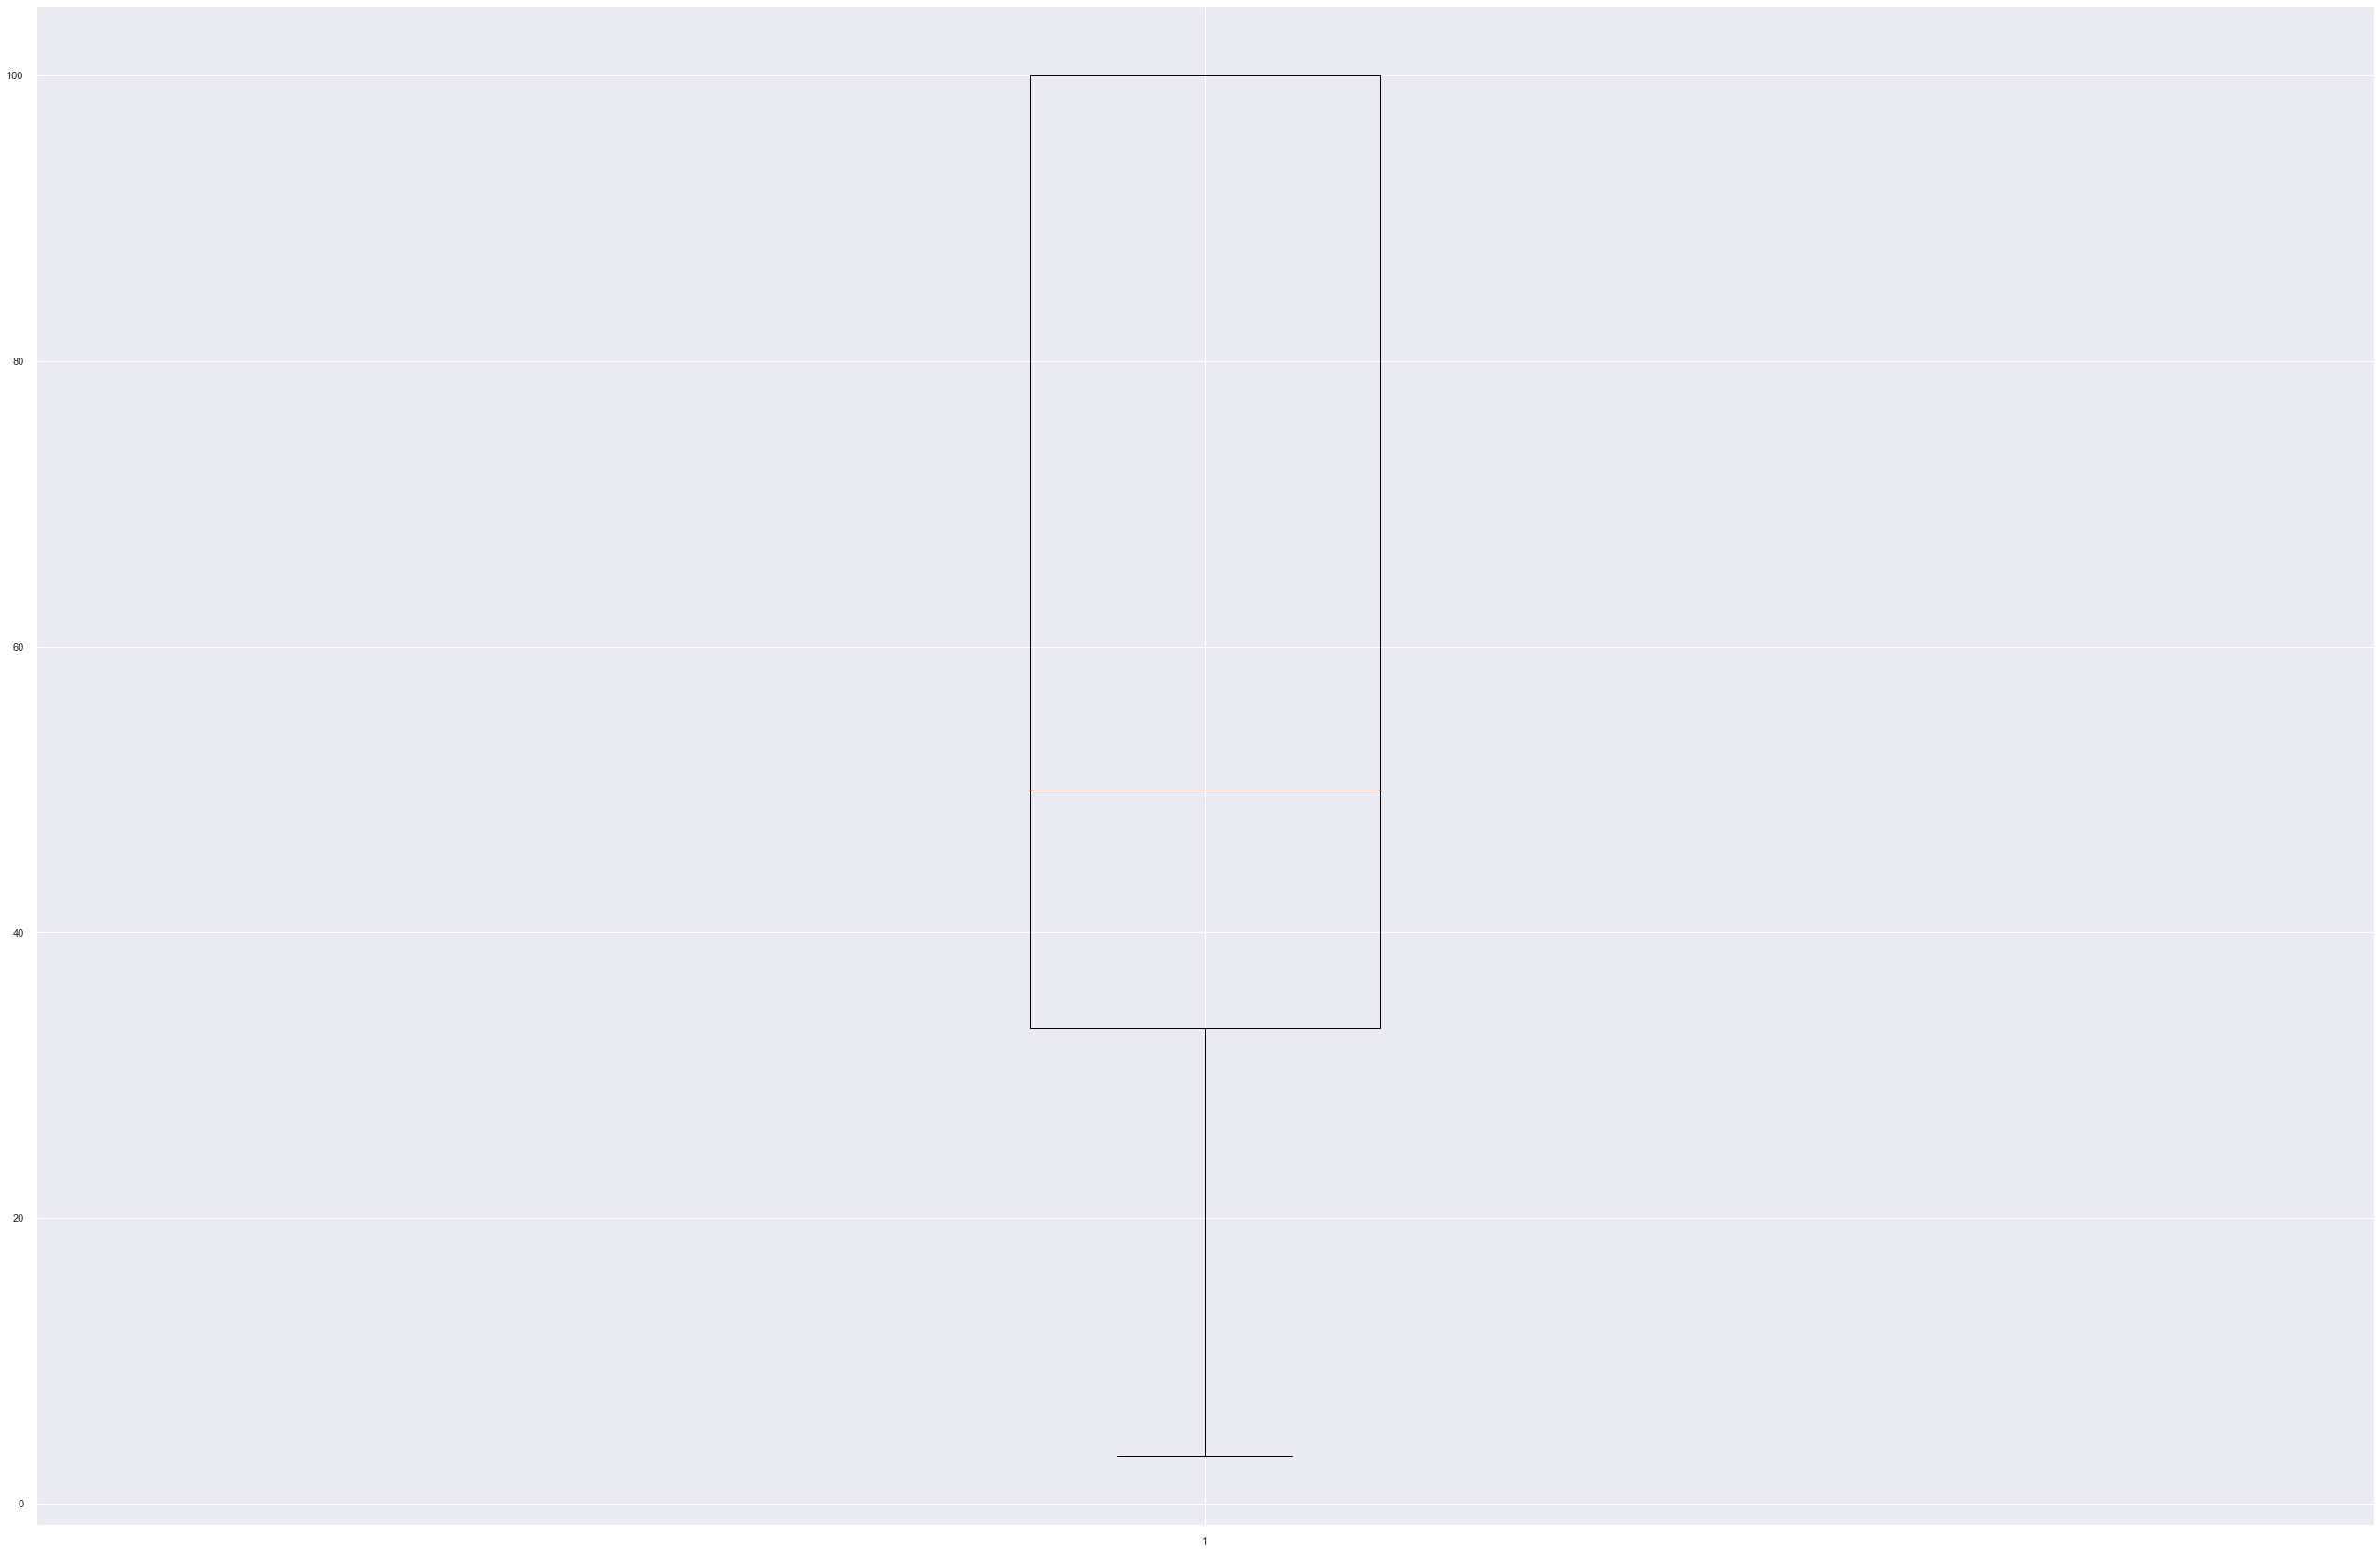

In [121]:
total['F_RATIO'] = (total['FATALS']/(total['PERSONS']+total['PEDS'])*100).round(3)
total.dropna()
plt.boxplot(total['F_RATIO']);

In [122]:
total.columns

Index(['STATENAME', 'VE_TOTAL', 'PEDS', 'PERSONS', 'DAYNAME', 'MONTHNAME',
       'HOUR', 'DAY_WEEKNAME', 'RUR_URBNAME', 'HARM_EVNAME', 'LGT_CONDNAME',
       'WEATHER1NAME', 'WEATHERNAME', 'FATALS', 'DRUNK_DR', 'REGION',
       'WEEK_END', 'DAY_NIGHT', 'DayNight_Avg', 'WEEK_END_Avg', 'State_Avg',
       'Day_Avg', 'Region_Avg', 'F_RATIO'],
      dtype='object')

In [123]:
np.mean(total['F_RATIO'])

57.35825497924577

In [124]:
total['F_RATIO'].std()

28.516912132547265

In [125]:
### F_RATIO looks useable, so let's sort the dataframe by it to help plotting
total = total.sort_values(by = 'F_RATIO', ascending=False)

In [126]:
total.head()

,STATENAME,VE_TOTAL,PEDS,PERSONS,DAYNAME,MONTHNAME,HOUR,DAY_WEEKNAME,RUR_URBNAME,HARM_EVNAME,...,DRUNK_DR,REGION,WEEK_END,DAY_NIGHT,DayNight_Avg,WEEK_END_Avg,State_Avg,Day_Avg,Region_Avg,F_RATIO
8293,Florida,1,0,1,6,August,7,Tuesday,Urban,Curb,...,0,South,Weekday,Day_Time,1.086892,1.078599,1.078930,1.078794,1.085113,100.0
9639,Georgia,1,0,1,10,January,20,Thursday,Urban,Ditch,...,0,South,Weekday,Night_Time,1.085086,1.078599,1.082242,1.072604,1.085113,100.0
9630,Georgia,1,0,1,6,January,16,Sunday,Rural,Rollover/Overturn,...,0,South,Weekend,Night_Time,1.085086,1.100224,1.082242,1.100687,1.085113,100.0
9631,Georgia,1,0,1,7,January,21,Monday,Urban,Fence,...,0,South,Weekday,Night_Time,1.085086,1.078599,1.082242,1.073699,1.085113,100.0
23088,Ohio,1,0,1,28,July,23,Sunday,Rural,Utility Pole/Light Support,...,0,Midwest,Weekend,Night_Time,1.085086,1.100224,1.109827,1.100687,1.093226,100.0


In [127]:
total.WEATHER1NAME.value_counts()

Clear                       22538
Cloudy                       4951
Rain                         2501
Not Reported                 2309
Fog, Smog, Smoke              340
Snow                          304
Reported as Unknown           121
Severe Crosswinds              47
Sleet or Hail                  37
Freezing Rain or Drizzle       33
Other                          26
Blowing Snow                   22
Blowing Sand, Soil, Dirt        9
Name: WEATHER1NAME, dtype: int64

In [128]:
total['LGT_CONDNAME'].value_counts()

Daylight                   15760
Dark - Not Lighted          8939
Dark - Lighted              6704
Dusk                         754
Dawn                         672
Dark - Unknown Lighting      254
Reported as Unknown          100
Not Reported                  42
Other                         13
Name: LGT_CONDNAME, dtype: int64

In [129]:
### Motor Vehicle In-Transport means any car on the road, moving or not moving
total['HARM_EVNAME'].nunique()

55

<a id="id4"></a>


### Dividing into Rural and Urban Datasets

In [130]:
rural = total[total.RUR_URBNAME == 'Rural']
rural.RUR_URBNAME.value_counts()

Rural    14452
Name: RUR_URBNAME, dtype: int64

In [131]:
urban = total[total.RUR_URBNAME == 'Urban']
urban.RUR_URBNAME.value_counts()

Urban    18681
Name: RUR_URBNAME, dtype: int64

<a id="id5"></a>

## Initial Exploration

In [132]:
rural.FATALS.describe()

count    14452.000000
mean         1.113756
std          0.401797
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: FATALS, dtype: float64

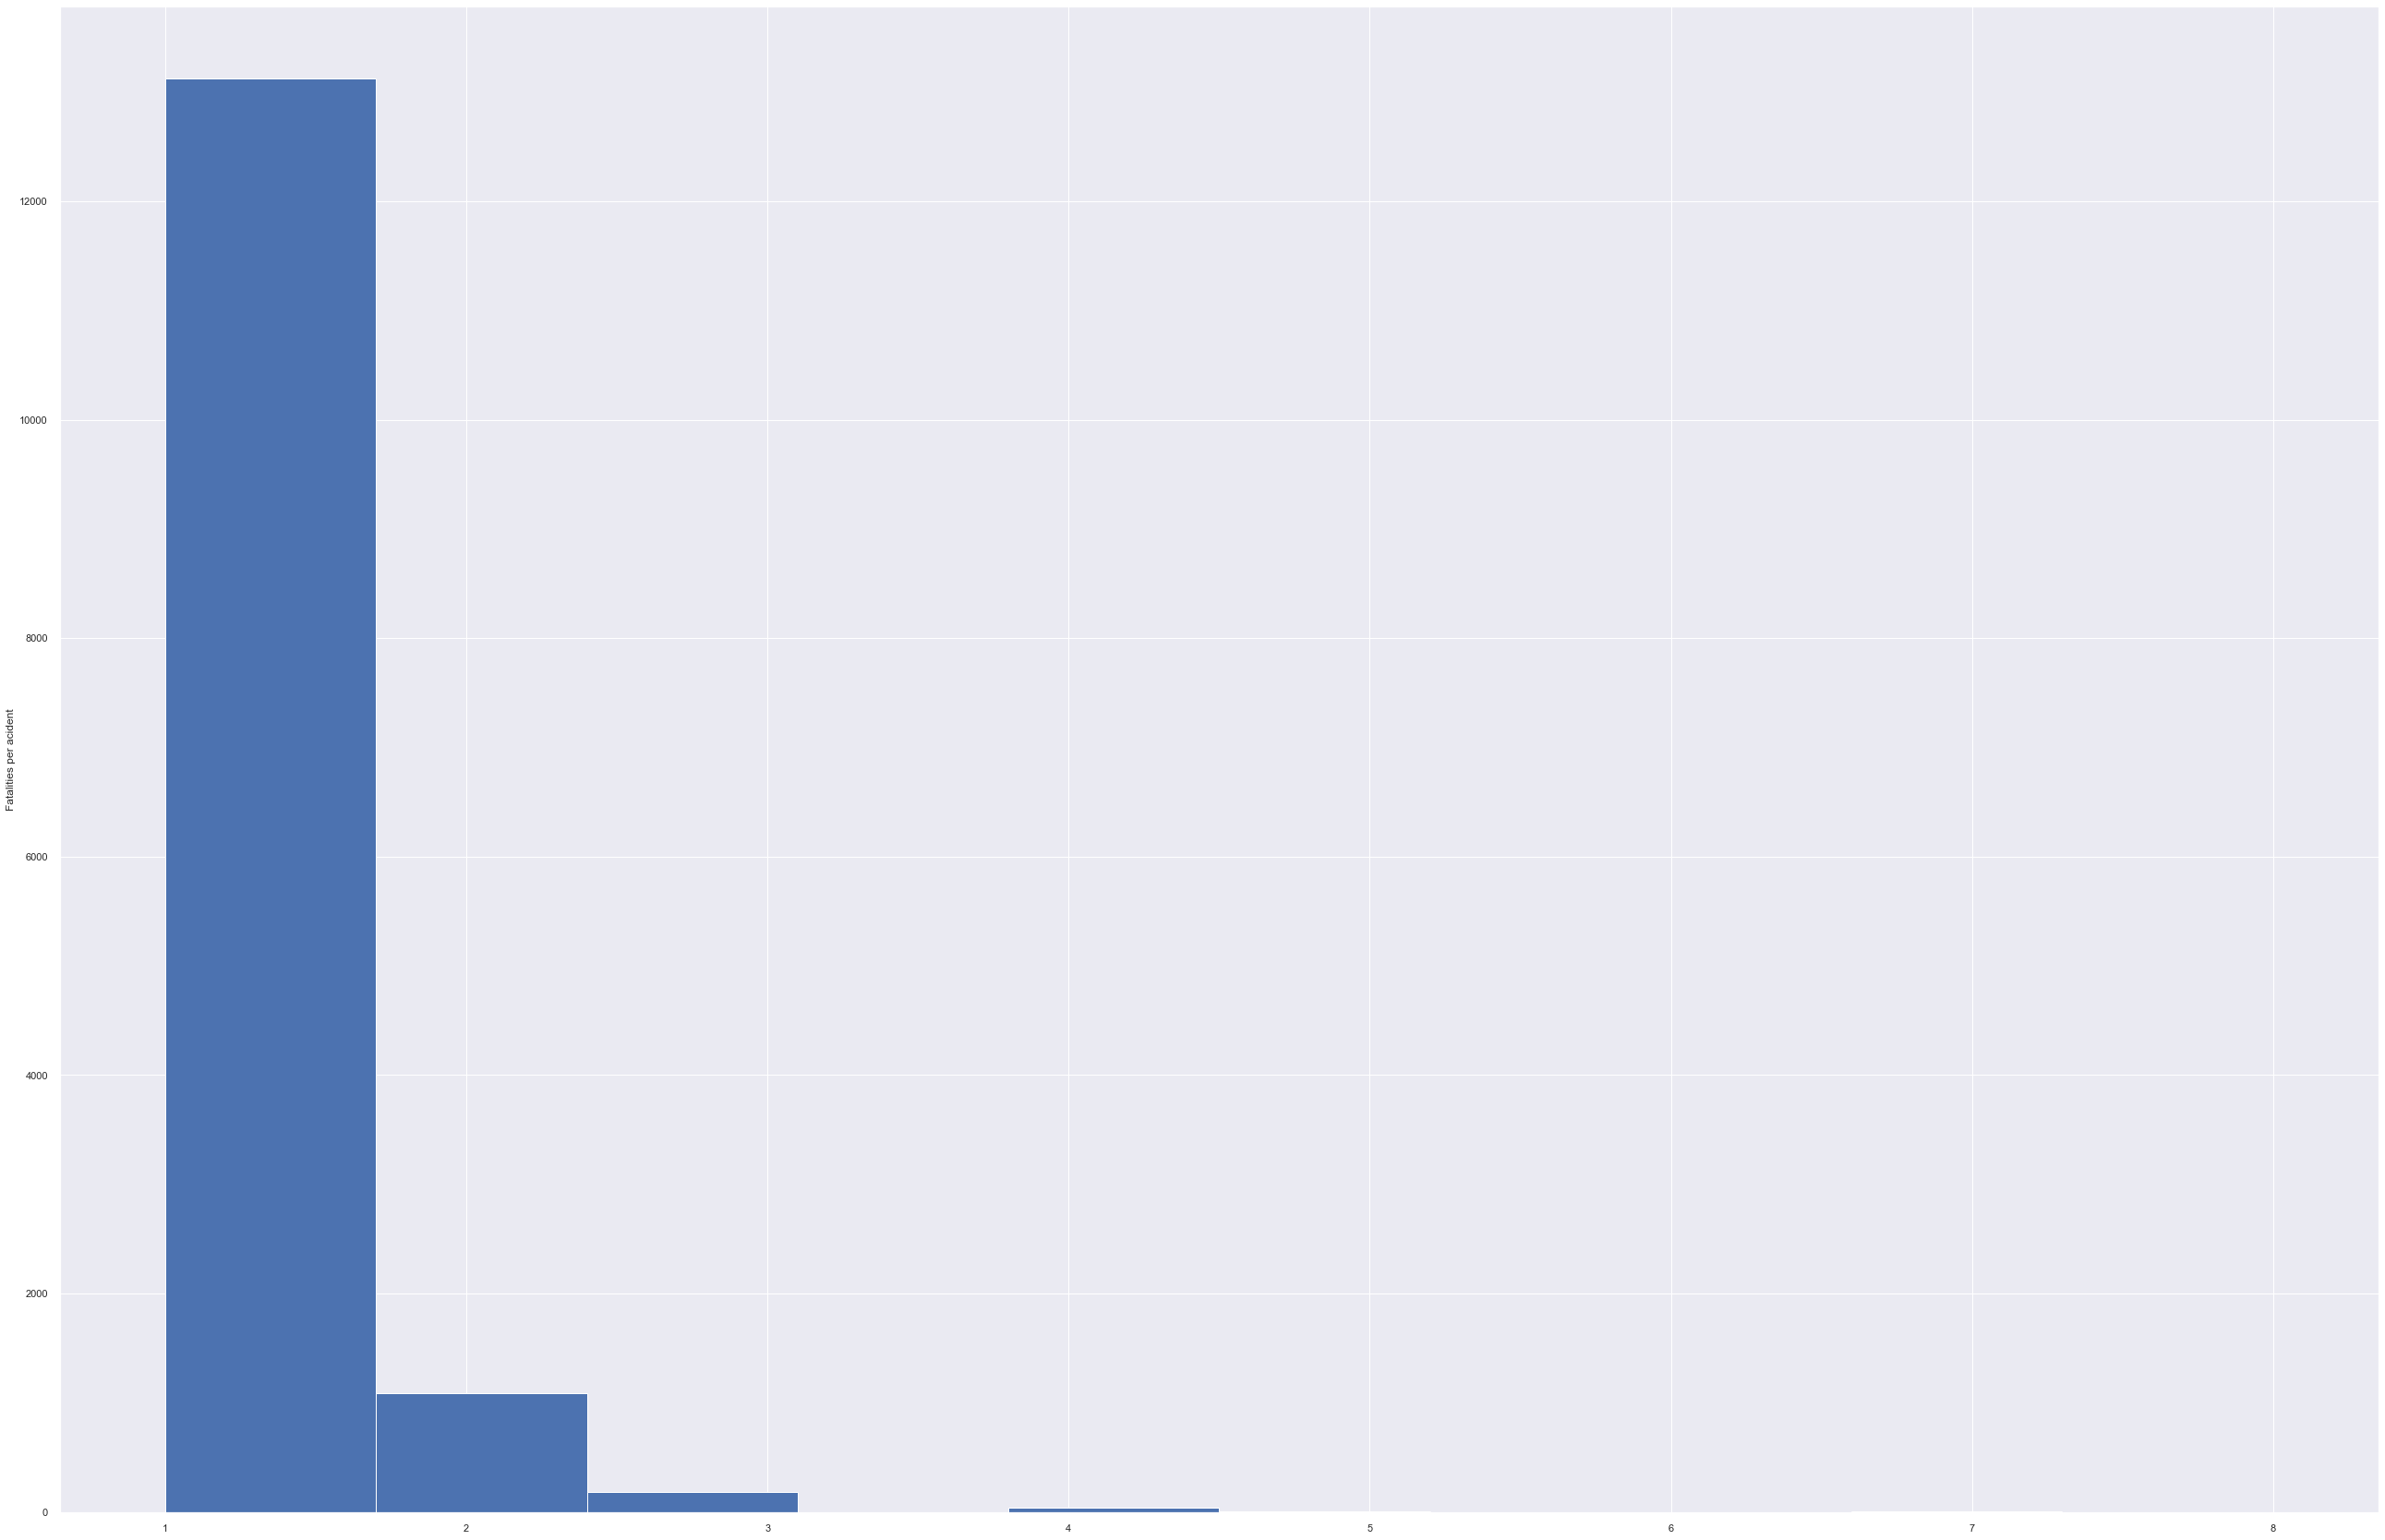

In [133]:
# USE CATPLOT TO GET SIMPLE GRAPHIC ASSESSMENTS Matplotlib, pandas, and Seaborn
_ = plt.hist(rural.FATALS);


# Label the axes

_ = plt.ylabel('Fatalities per acident')


# Show the plot
plt.show()



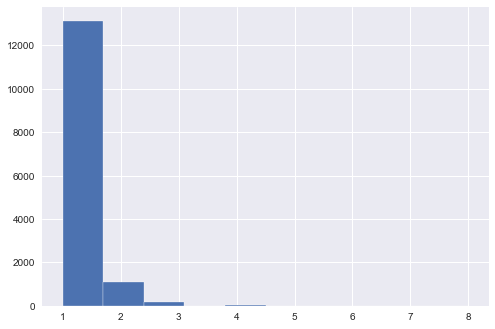

In [169]:
plt.style.use('seaborn')
rural.FATALS.hist();

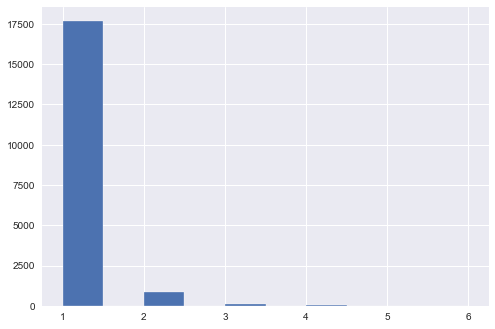

In [170]:
plt.style.use('seaborn')
urban.FATALS.hist();

Most of the accidents in rural and urban areas have 1 fatality per accident. Not a lot will be gleaned from assessing fatalities per accident.

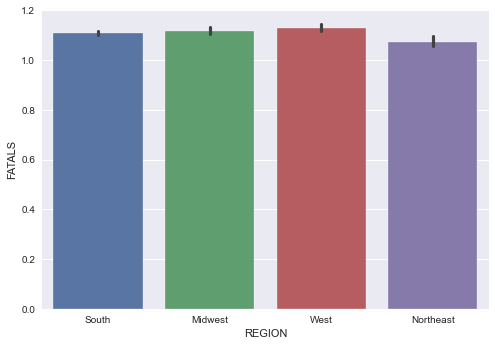

In [136]:
## A look at fatalities by state
sns.barplot(x=rural.REGION, y=rural.FATALS, data=rural)

plt.show()

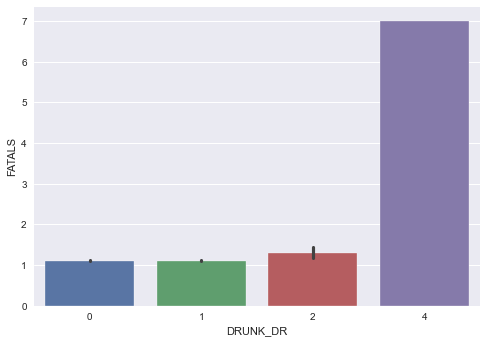

In [137]:
## A look at fatalities by state
sns.barplot(x=rural.DRUNK_DR, y=rural.FATALS, data=rural)

plt.show()

More than two drunk drivers really drives up the number of fatalities; but the Ns behind this outsized column might low.

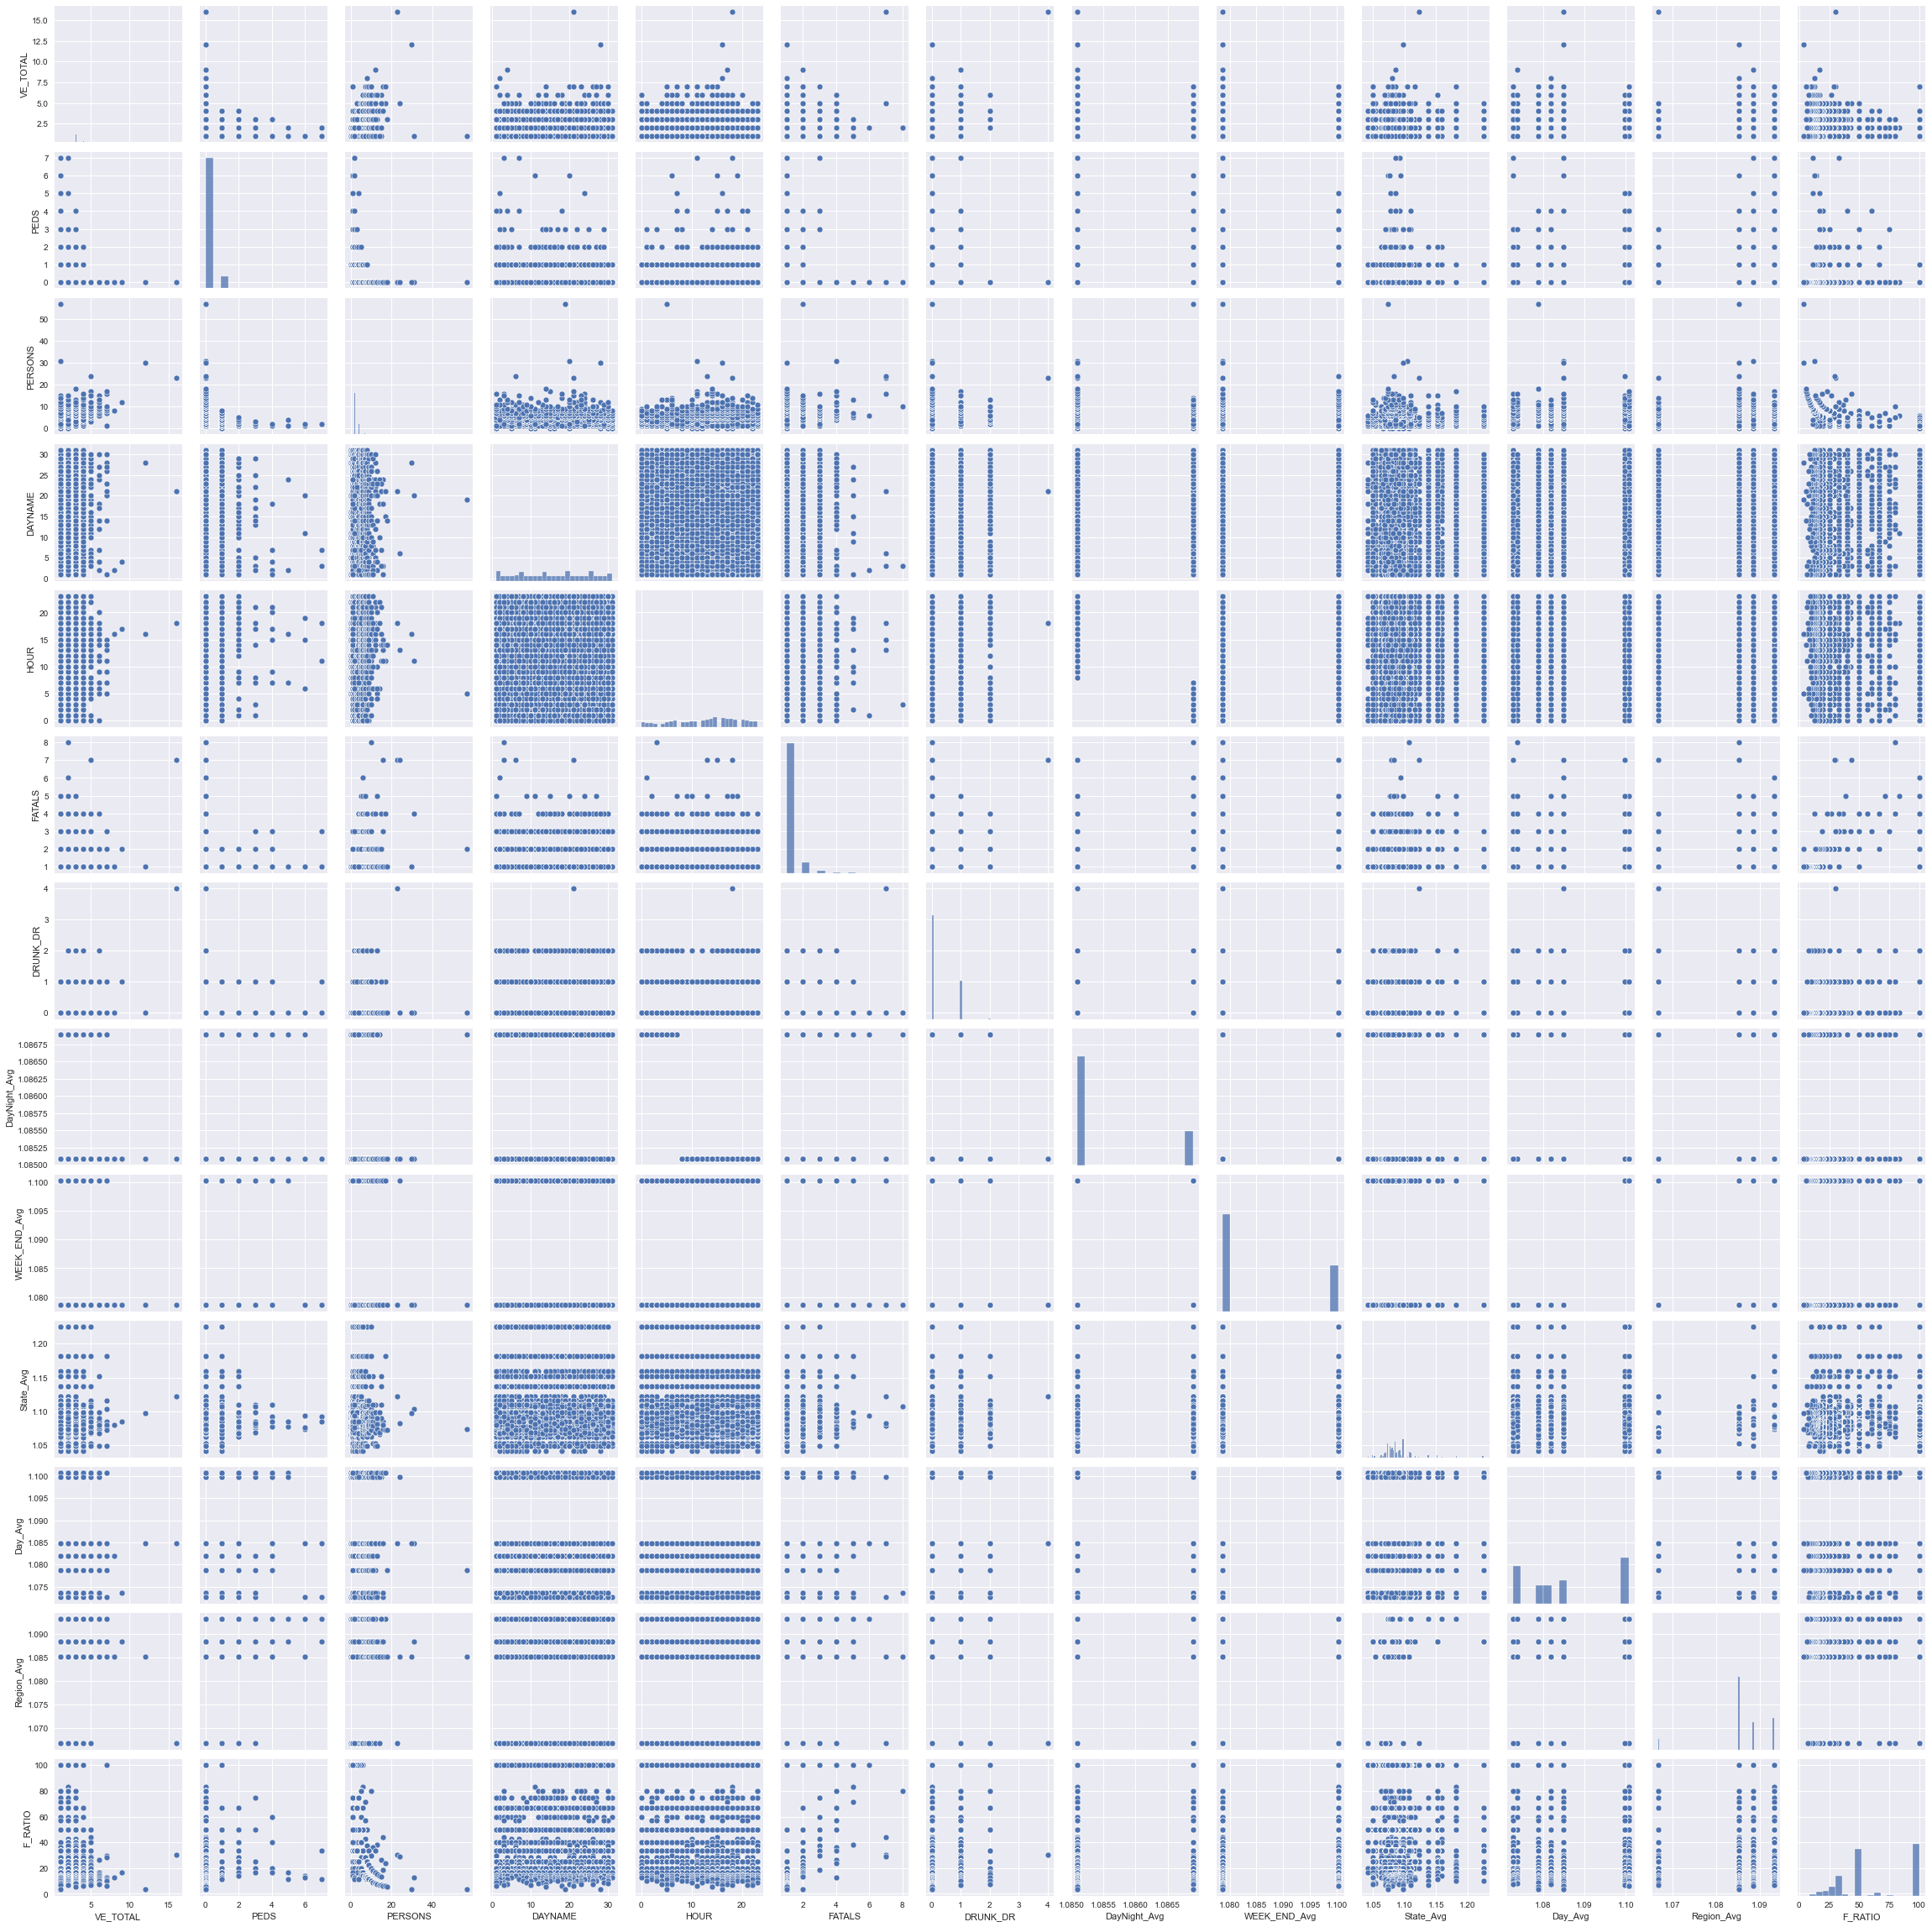

In [138]:
sns.pairplot(rural);

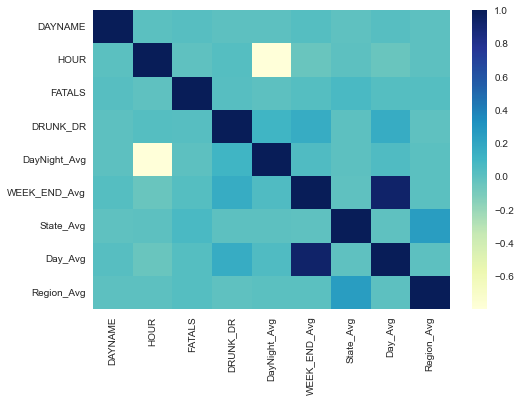

In [139]:
# Make a heatmap of the data 
correlation_matrix = rural.iloc[:,4:23].corr()
_ = sns.heatmap(correlation_matrix, cmap="YlGnBu")

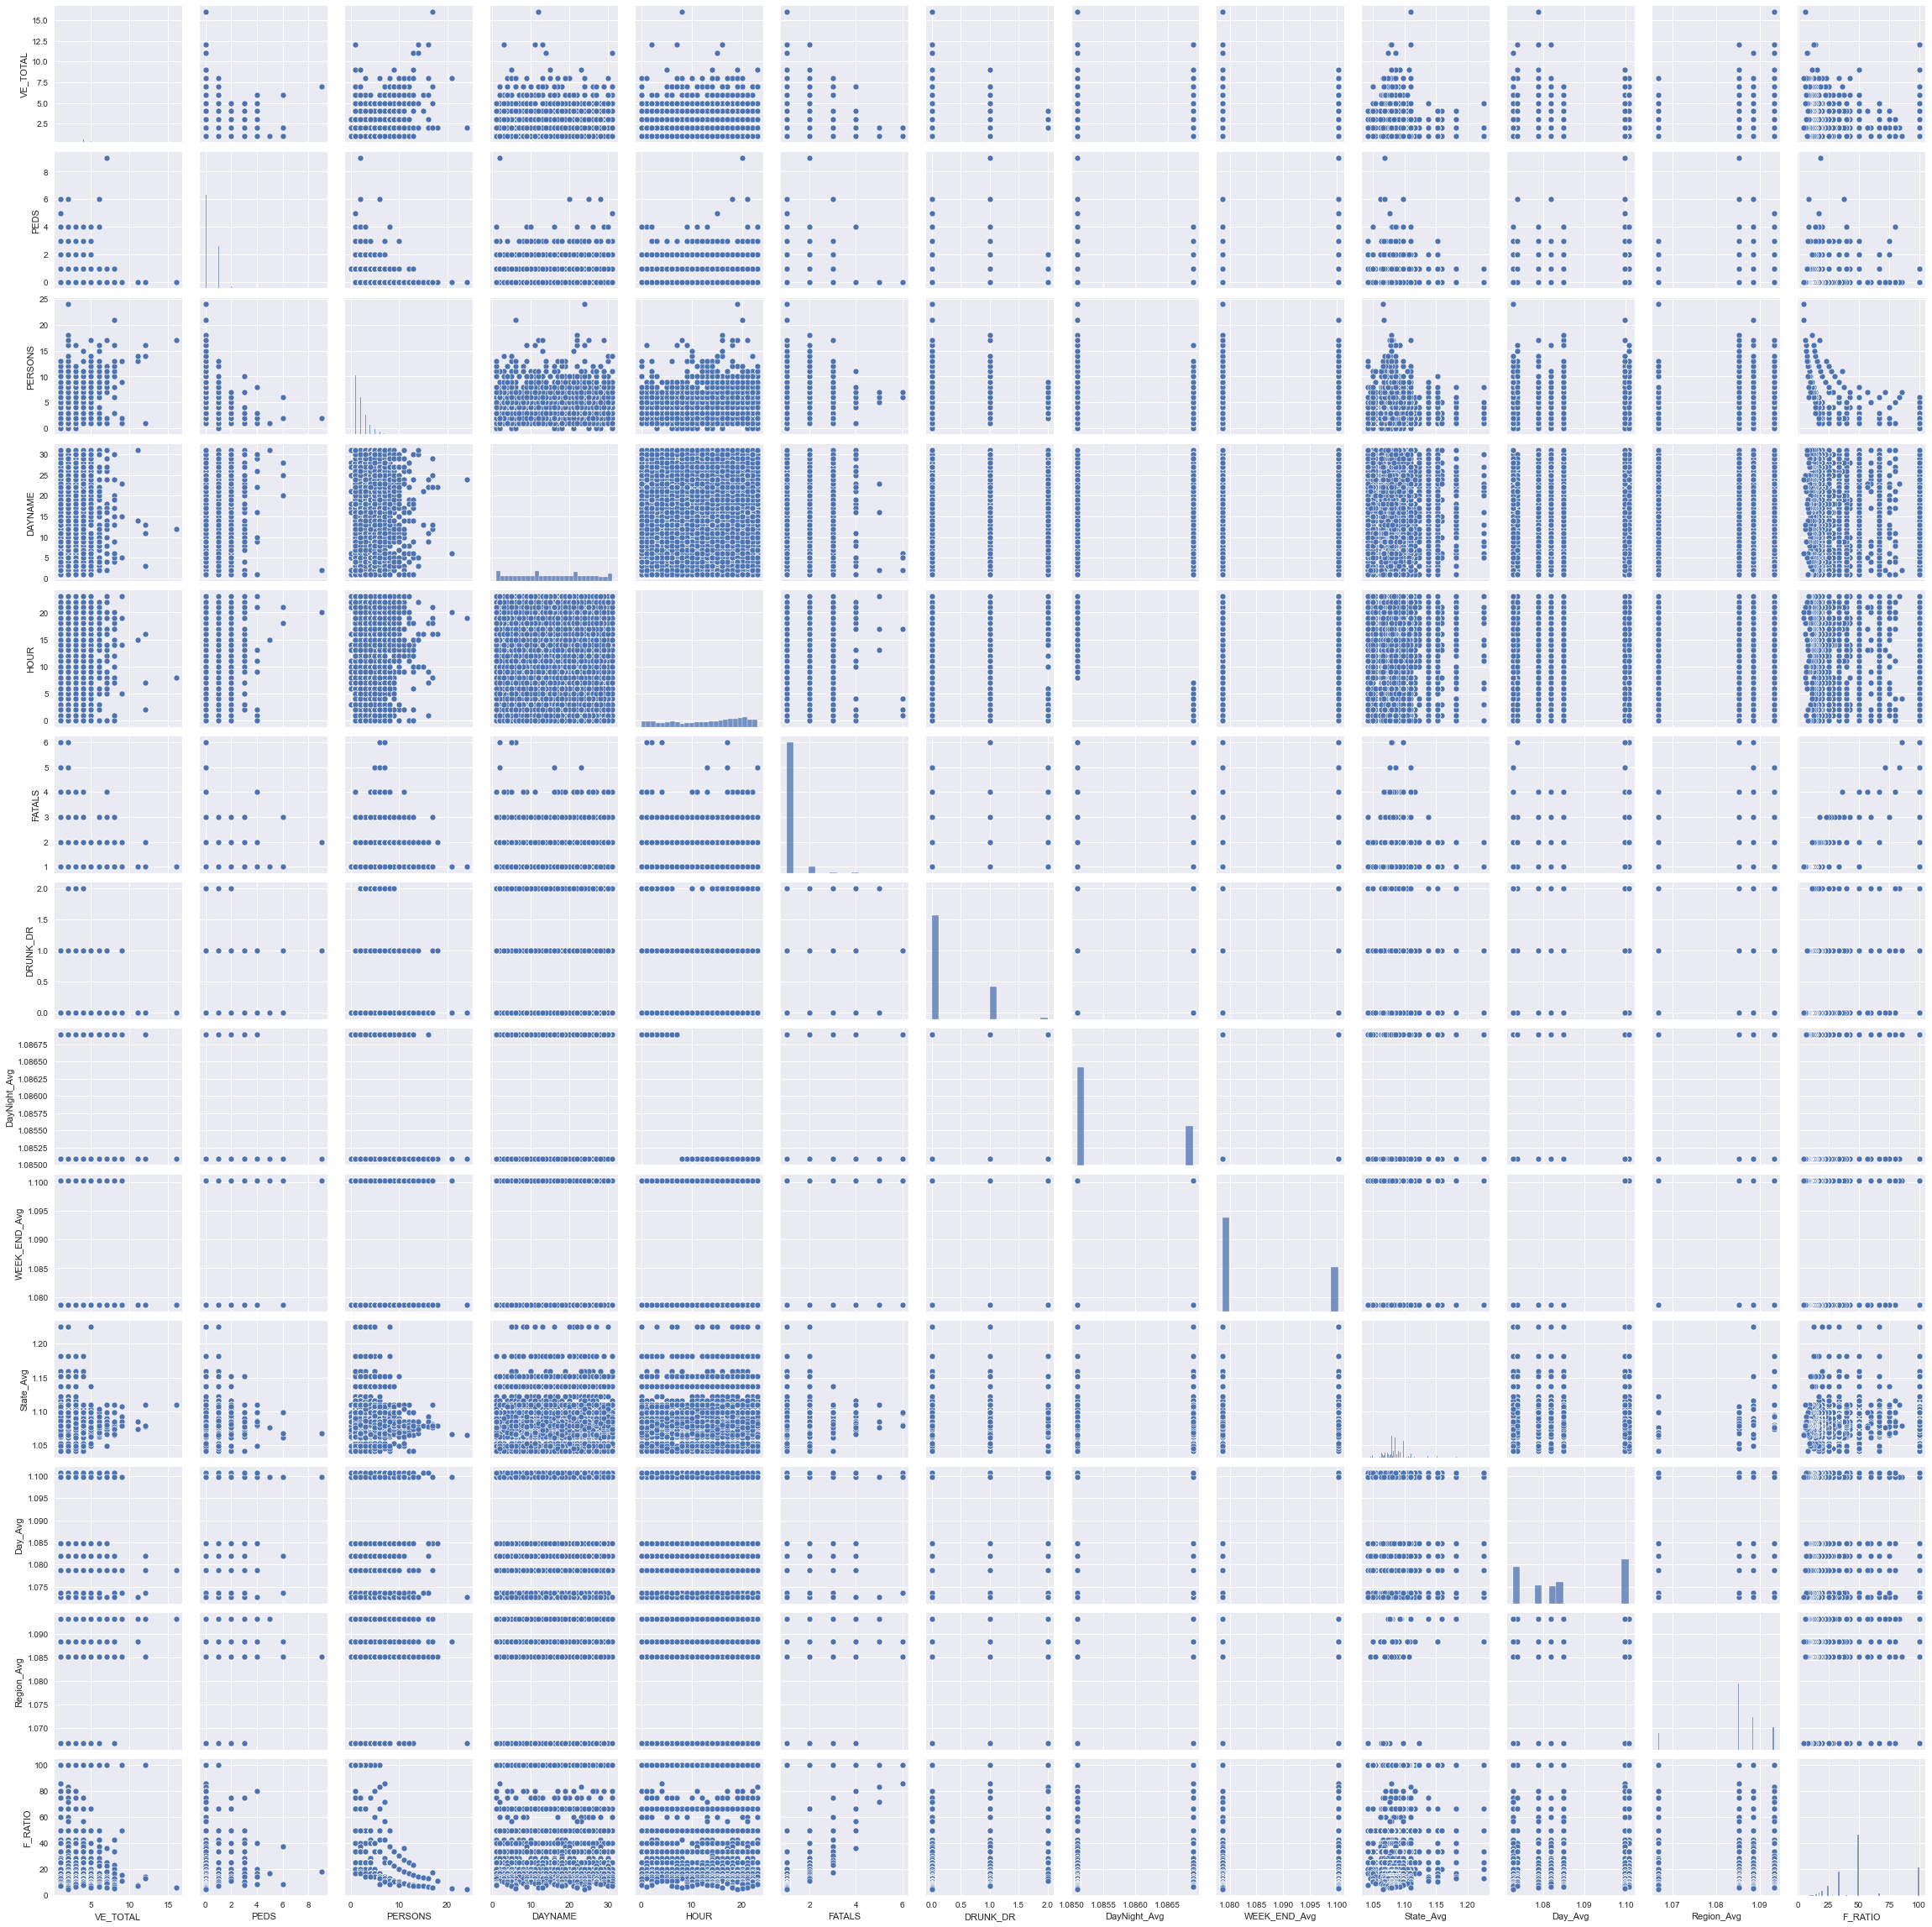

In [140]:
sns.pairplot(urban);

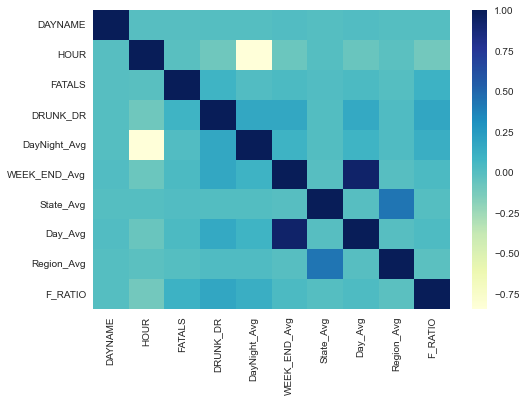

In [141]:
# Make a heatmap of the data 
correlation_matrix = urban.iloc[:,4:24].corr()
_ = sns.heatmap(correlation_matrix, cmap="YlGnBu")

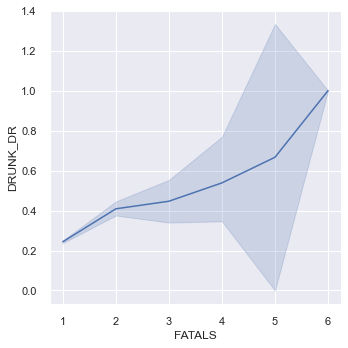

In [163]:
sns.relplot(y= urban['DRUNK_DR'], x=urban['FATALS'], kind='line' );

In [164]:
list_region = rural["REGION"].tolist()
list_fatals = rural['FATALS'].tolist()

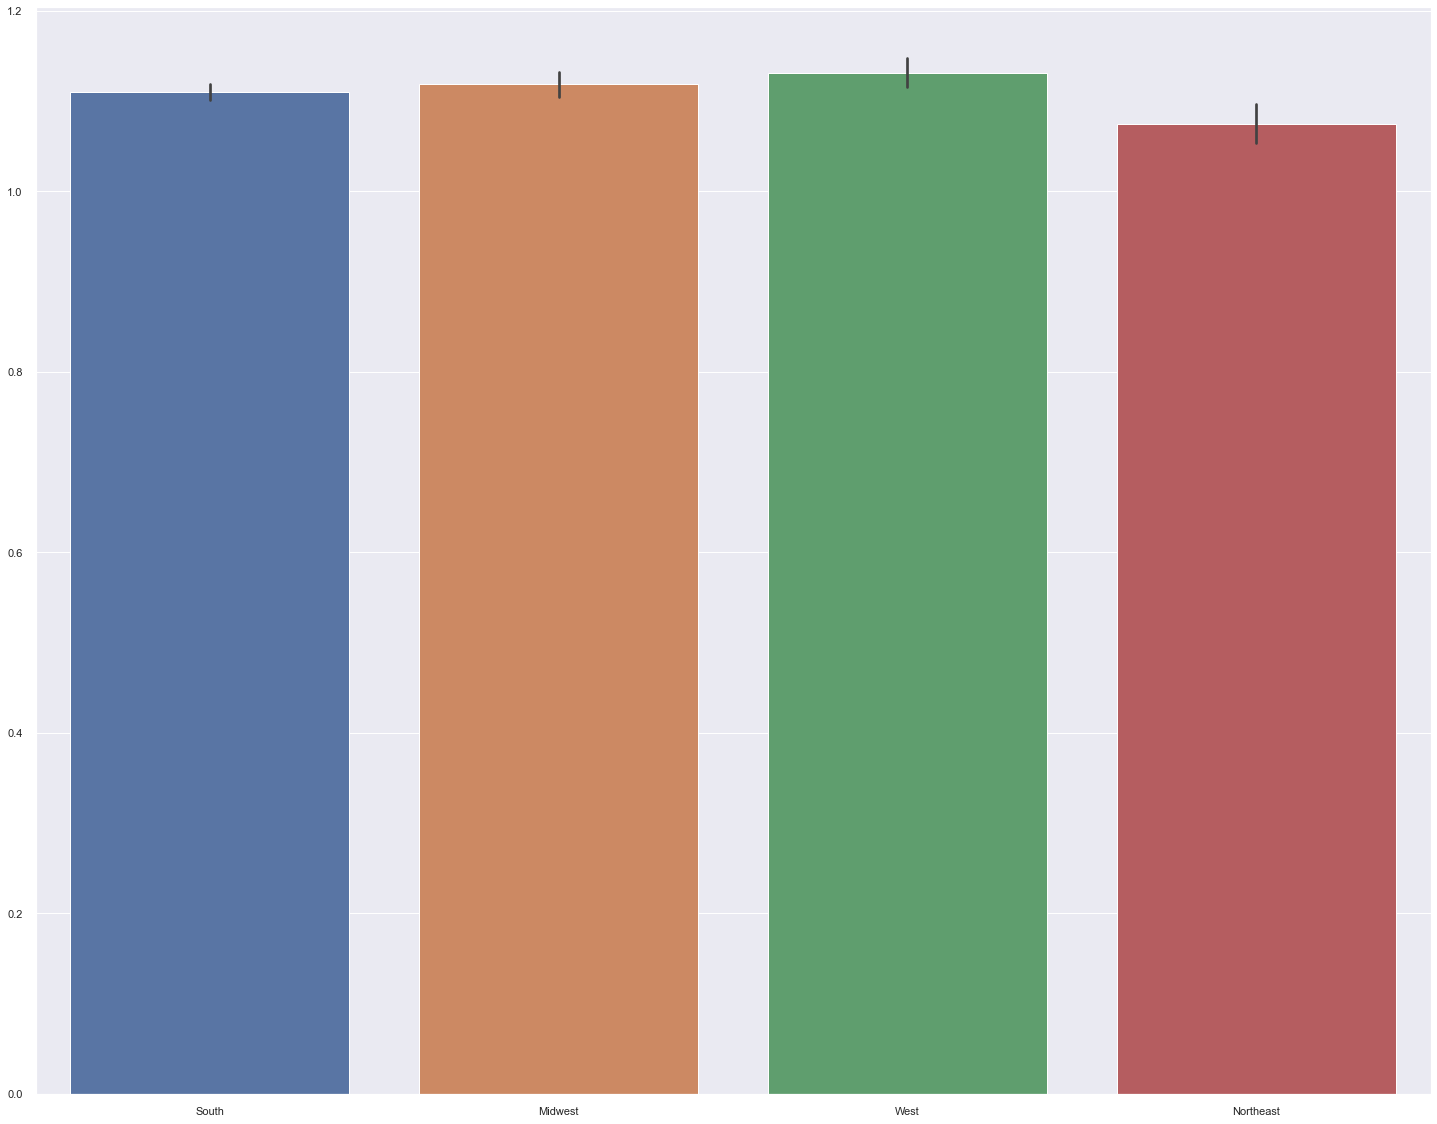

In [166]:
sns.barplot(x=list_region, y=list_fatals);

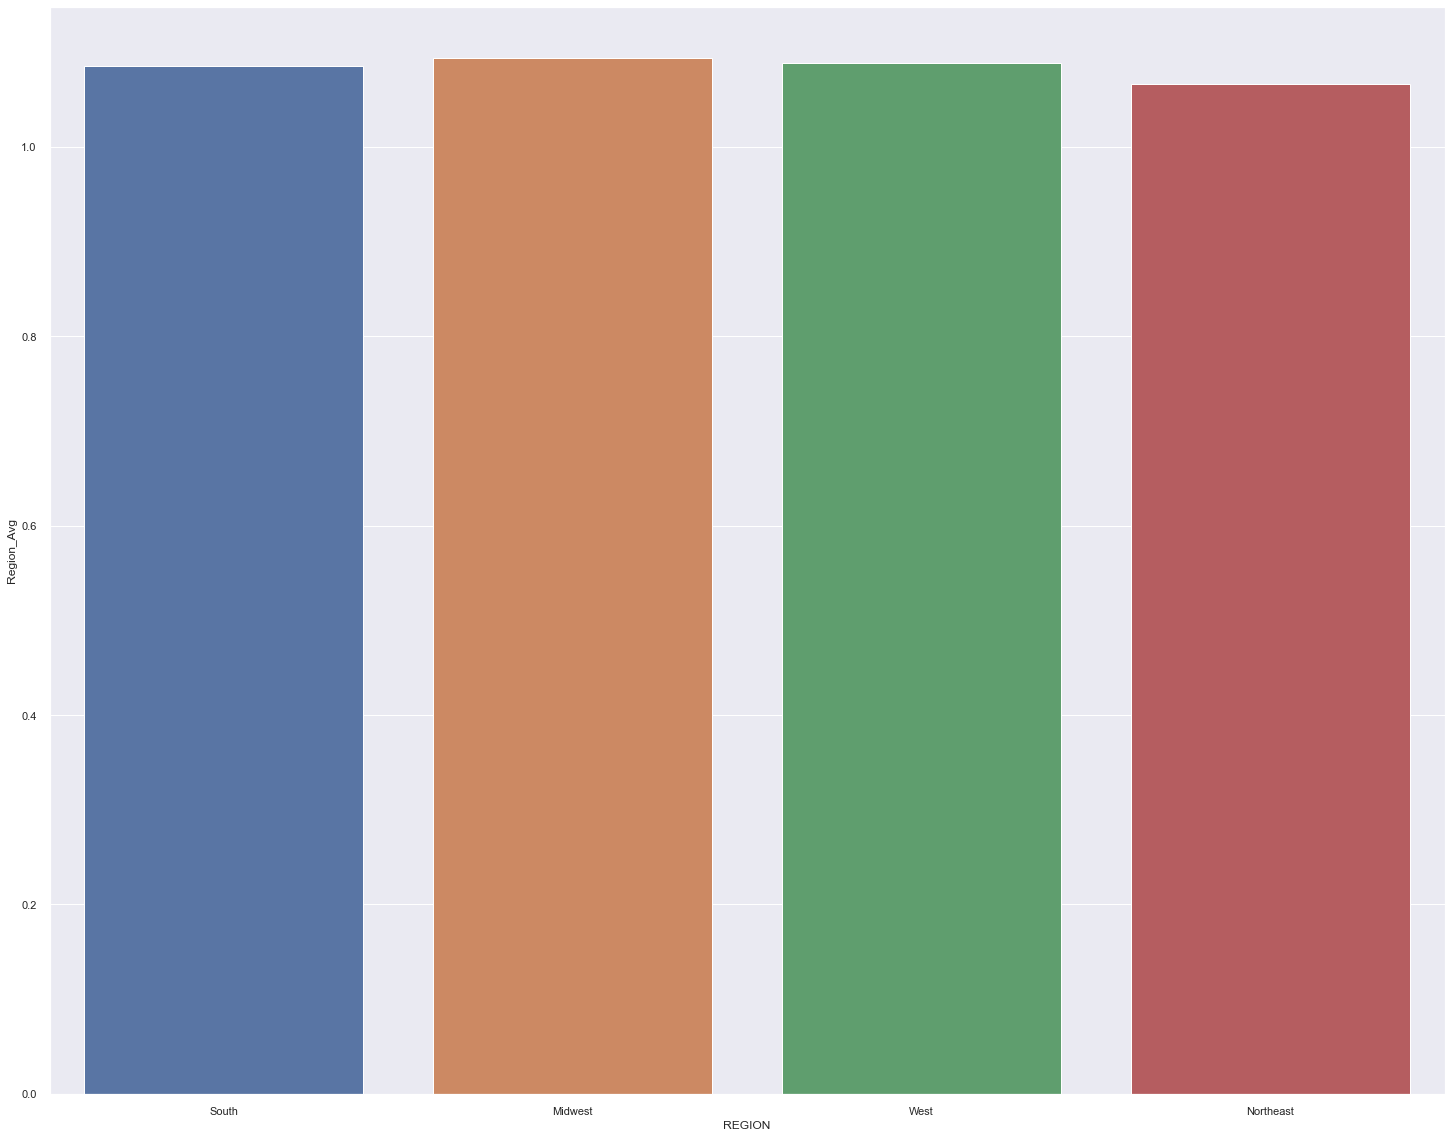

In [167]:
sns.barplot(x=total['REGION'], y=total['Region_Avg'])
plt.show;

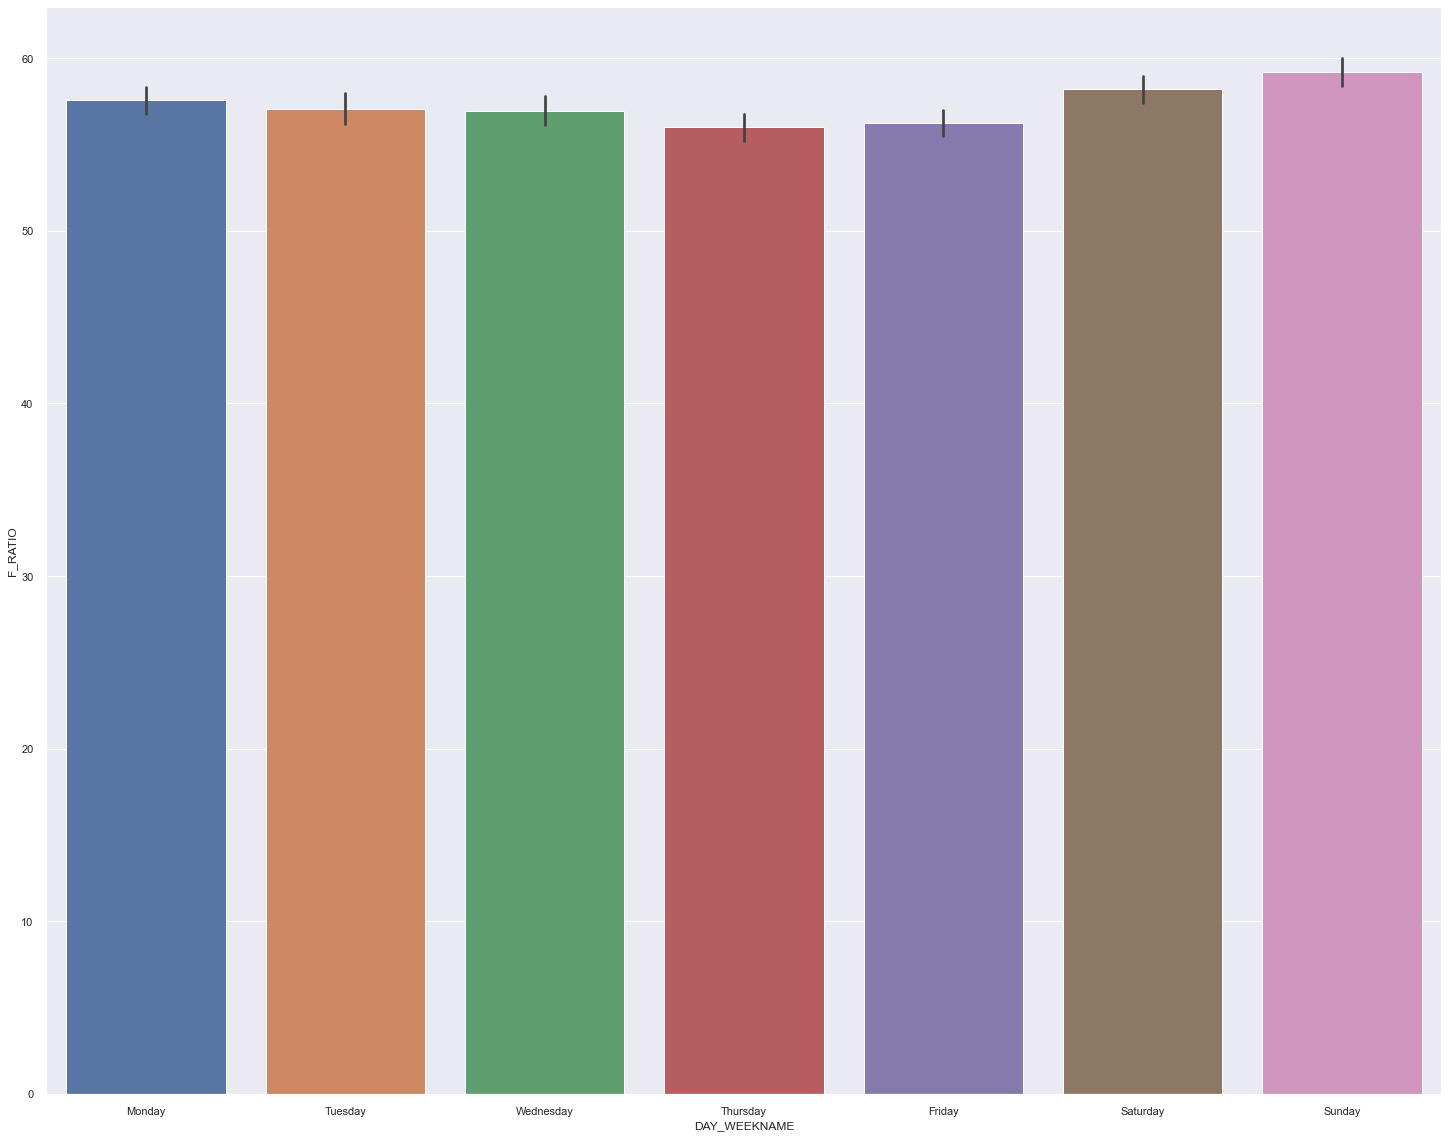

In [168]:
category_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
sns.barplot(x=total['DAY_WEEKNAME'], y=total['F_RATIO'], order=category_order)
plt.show;

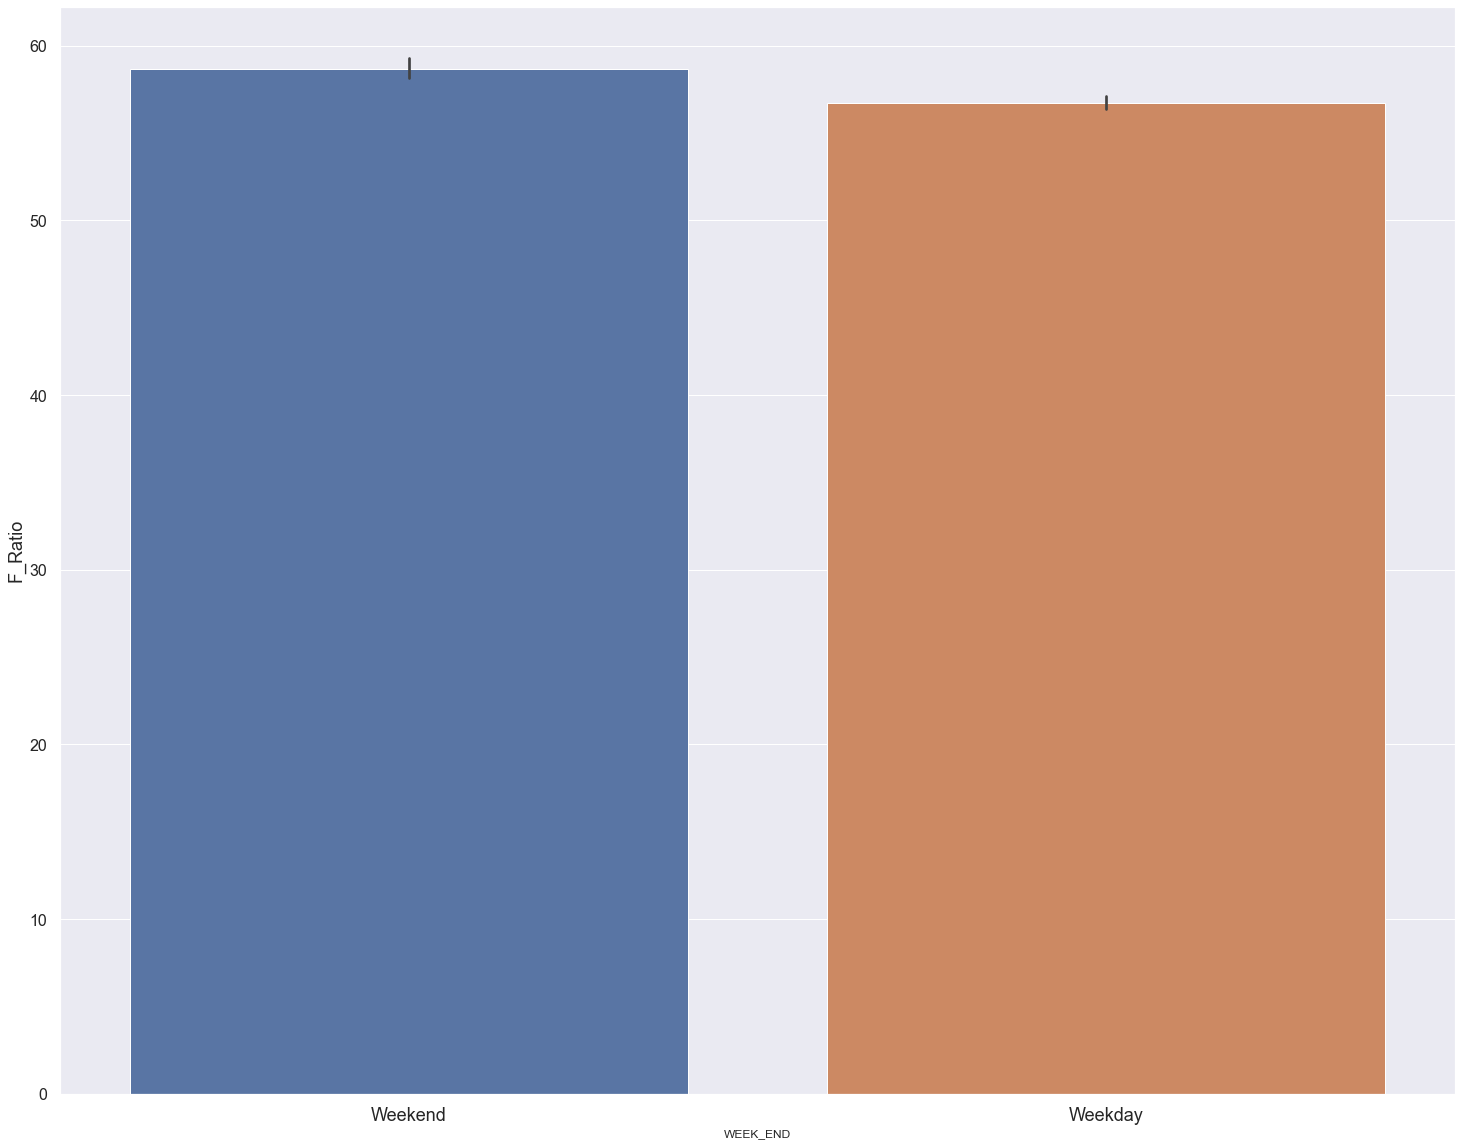

In [156]:
### slight increase in average fatalities for the weekend
sns.barplot(x=total['WEEK_END'], y=total['F_RATIO'], order=['Weekend', 'Weekday'])
plt.xticks(rotation = 0, fontsize=18)
plt.ylabel('F_Ratio', fontsize=18)
plt.yticks(fontsize=16)
plt.show;
plt.savefig('../reports/figures/F_Ratio for Weekday Weekend')
plt.show;

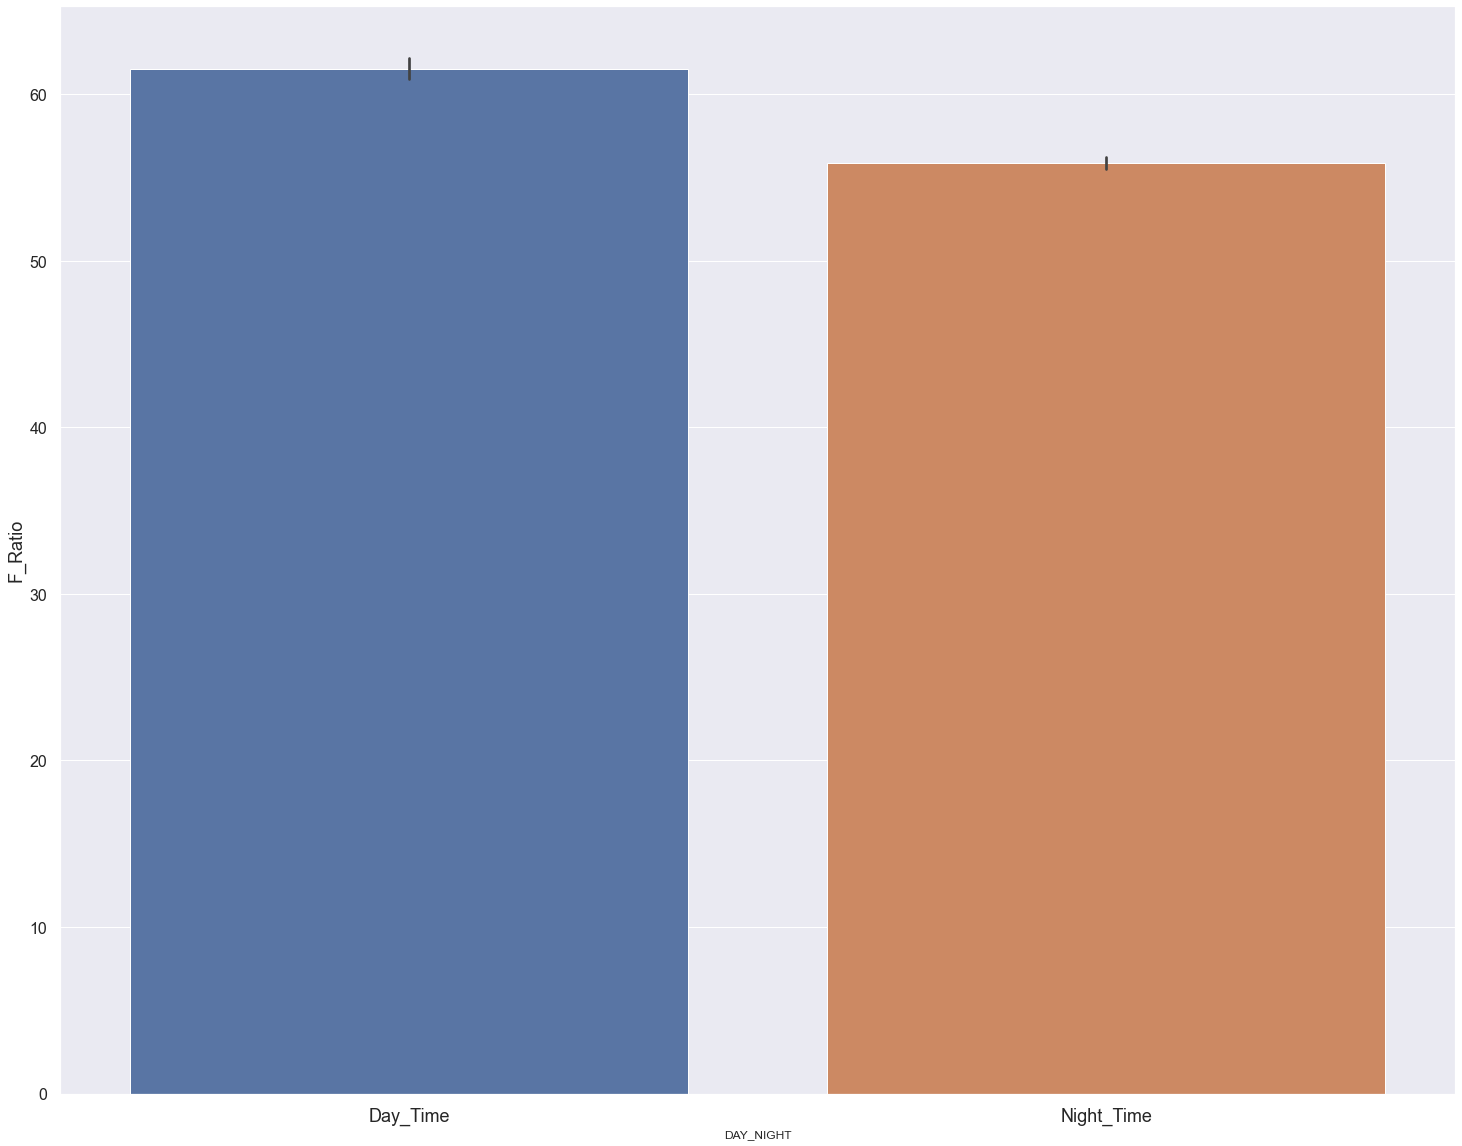

In [155]:
#No difference between number of fatalities in day time hours and those accidents in night time hours
sns.barplot(x=total['DAY_NIGHT'], y=total['F_RATIO'], order=['Day_Time', 'Night_Time'])
plt.xticks(rotation = 0, fontsize=18)
plt.ylabel('F_Ratio', fontsize=18)
plt.yticks(fontsize=16)
plt.show;
plt.savefig('../reports/figures/F_Ratio for Day or Night')
plt.show;

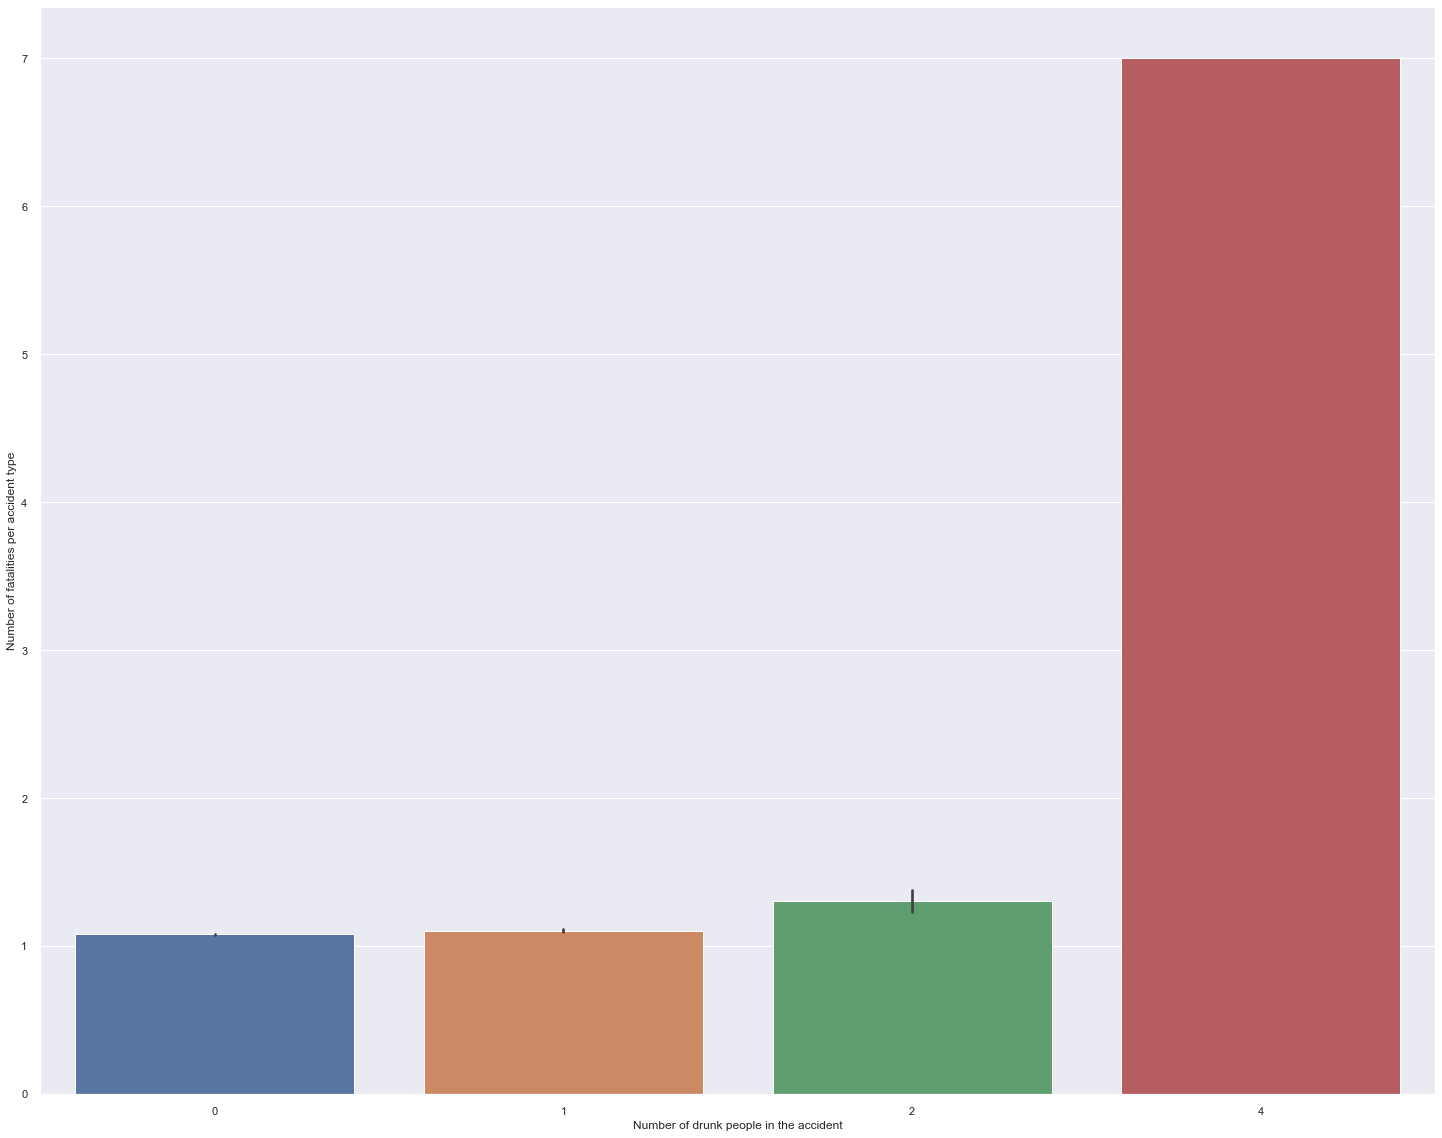

In [153]:
#Here are the difference between number of fatalities and how many drunk people involved (4 has 1 accident)
sns.barplot(x=total['DRUNK_DR'], y=total['FATALS'])
plt.xlabel('Number of drunk people in the accident')
plt.ylabel('Number of fatalities per accident type')
plt.show;

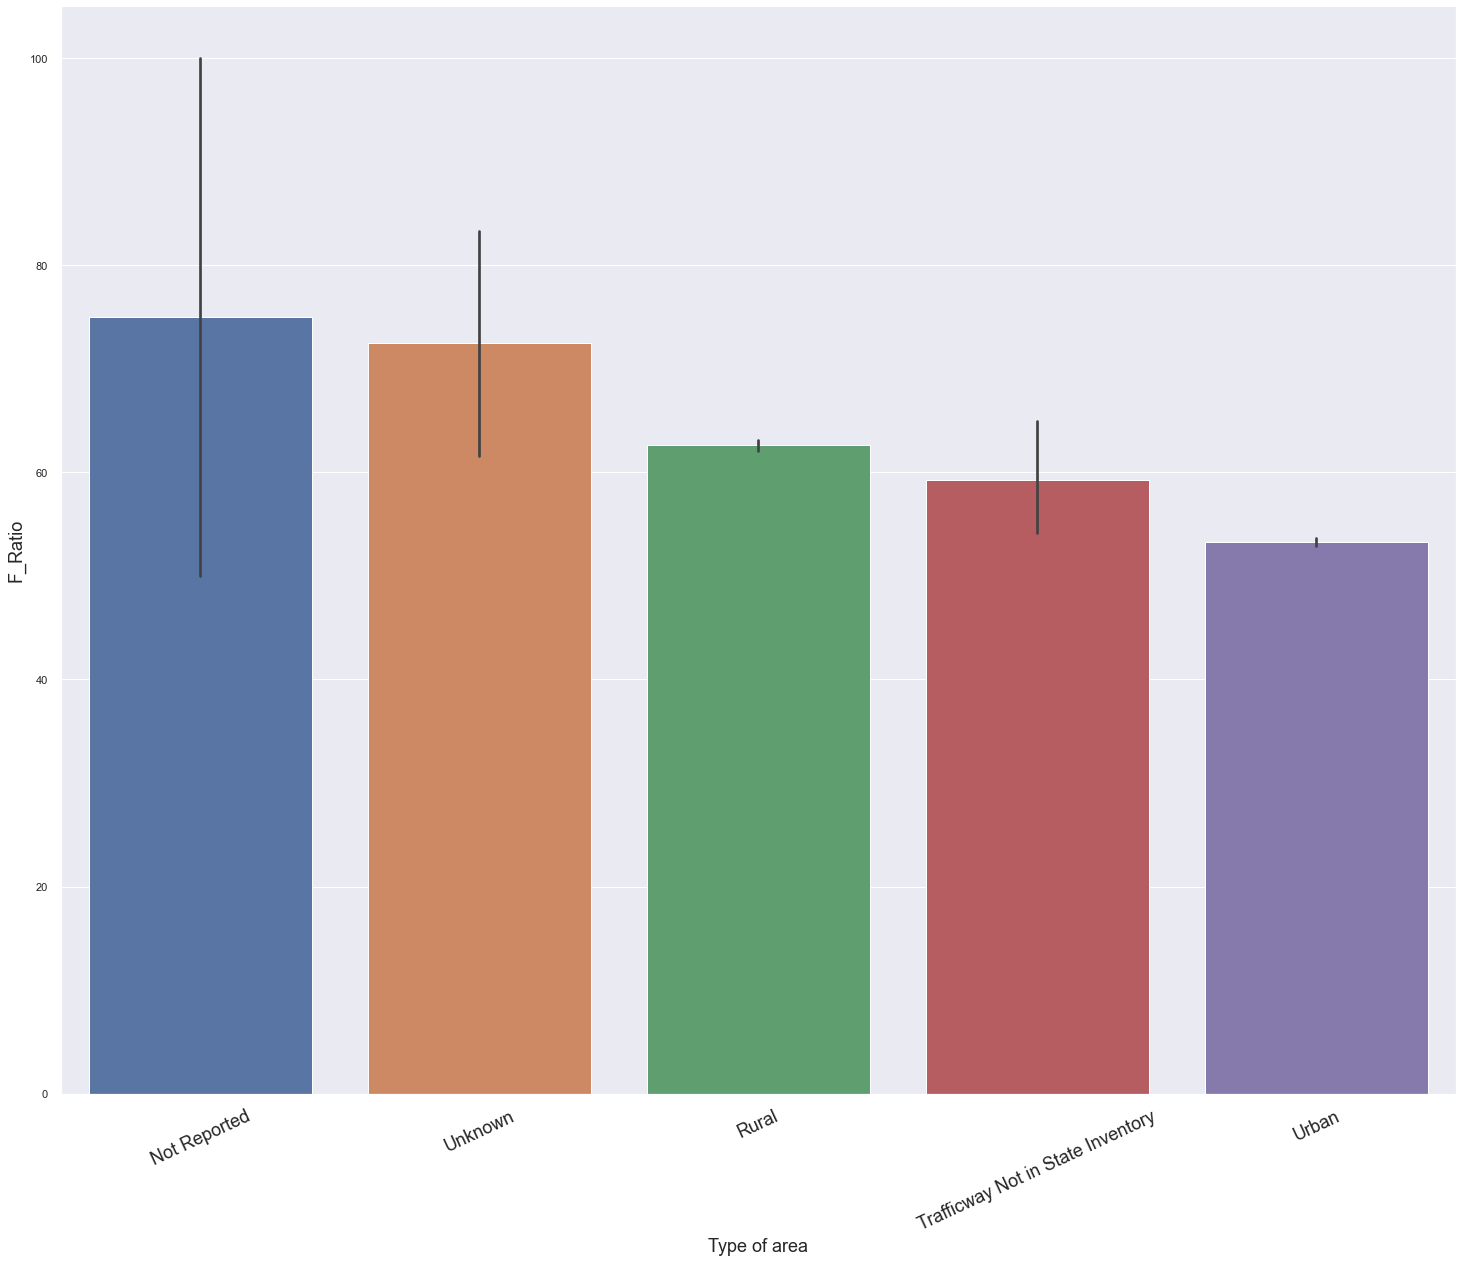

In [152]:
#Here are the difference between number of fatalities in area
result = total.groupby(['RUR_URBNAME'])['F_RATIO'].aggregate(np.mean).reset_index().sort_values('F_RATIO', ascending=False)
sns.barplot(x=total['RUR_URBNAME'], y=total['F_RATIO'], order=result['RUR_URBNAME'])
plt.xlabel('Type of area',fontsize=18)
plt.xticks(rotation = 25, fontsize=18)
plt.ylabel('F_Ratio', fontsize=18)
plt.show;
plt.savefig('../reports/figures/F_Ratio for Type of Area')

In [150]:
xticks=pd.factorize(total['WEATHERNAME'])
xticks

(array([0, 0, 0, ..., 0, 3, 0]),
 Index(['Clear', 'Cloudy', 'Rain', 'Fog, Smog, Smoke', 'Not Reported',
        'Reported as Unknown', 'Severe Crosswinds', 'Snow', 'Other',
        'Blowing Snow', 'Sleet or Hail', 'Freezing Rain or Drizzle',
        'Blowing Sand, Soil, Dirt'],
       dtype='object'))

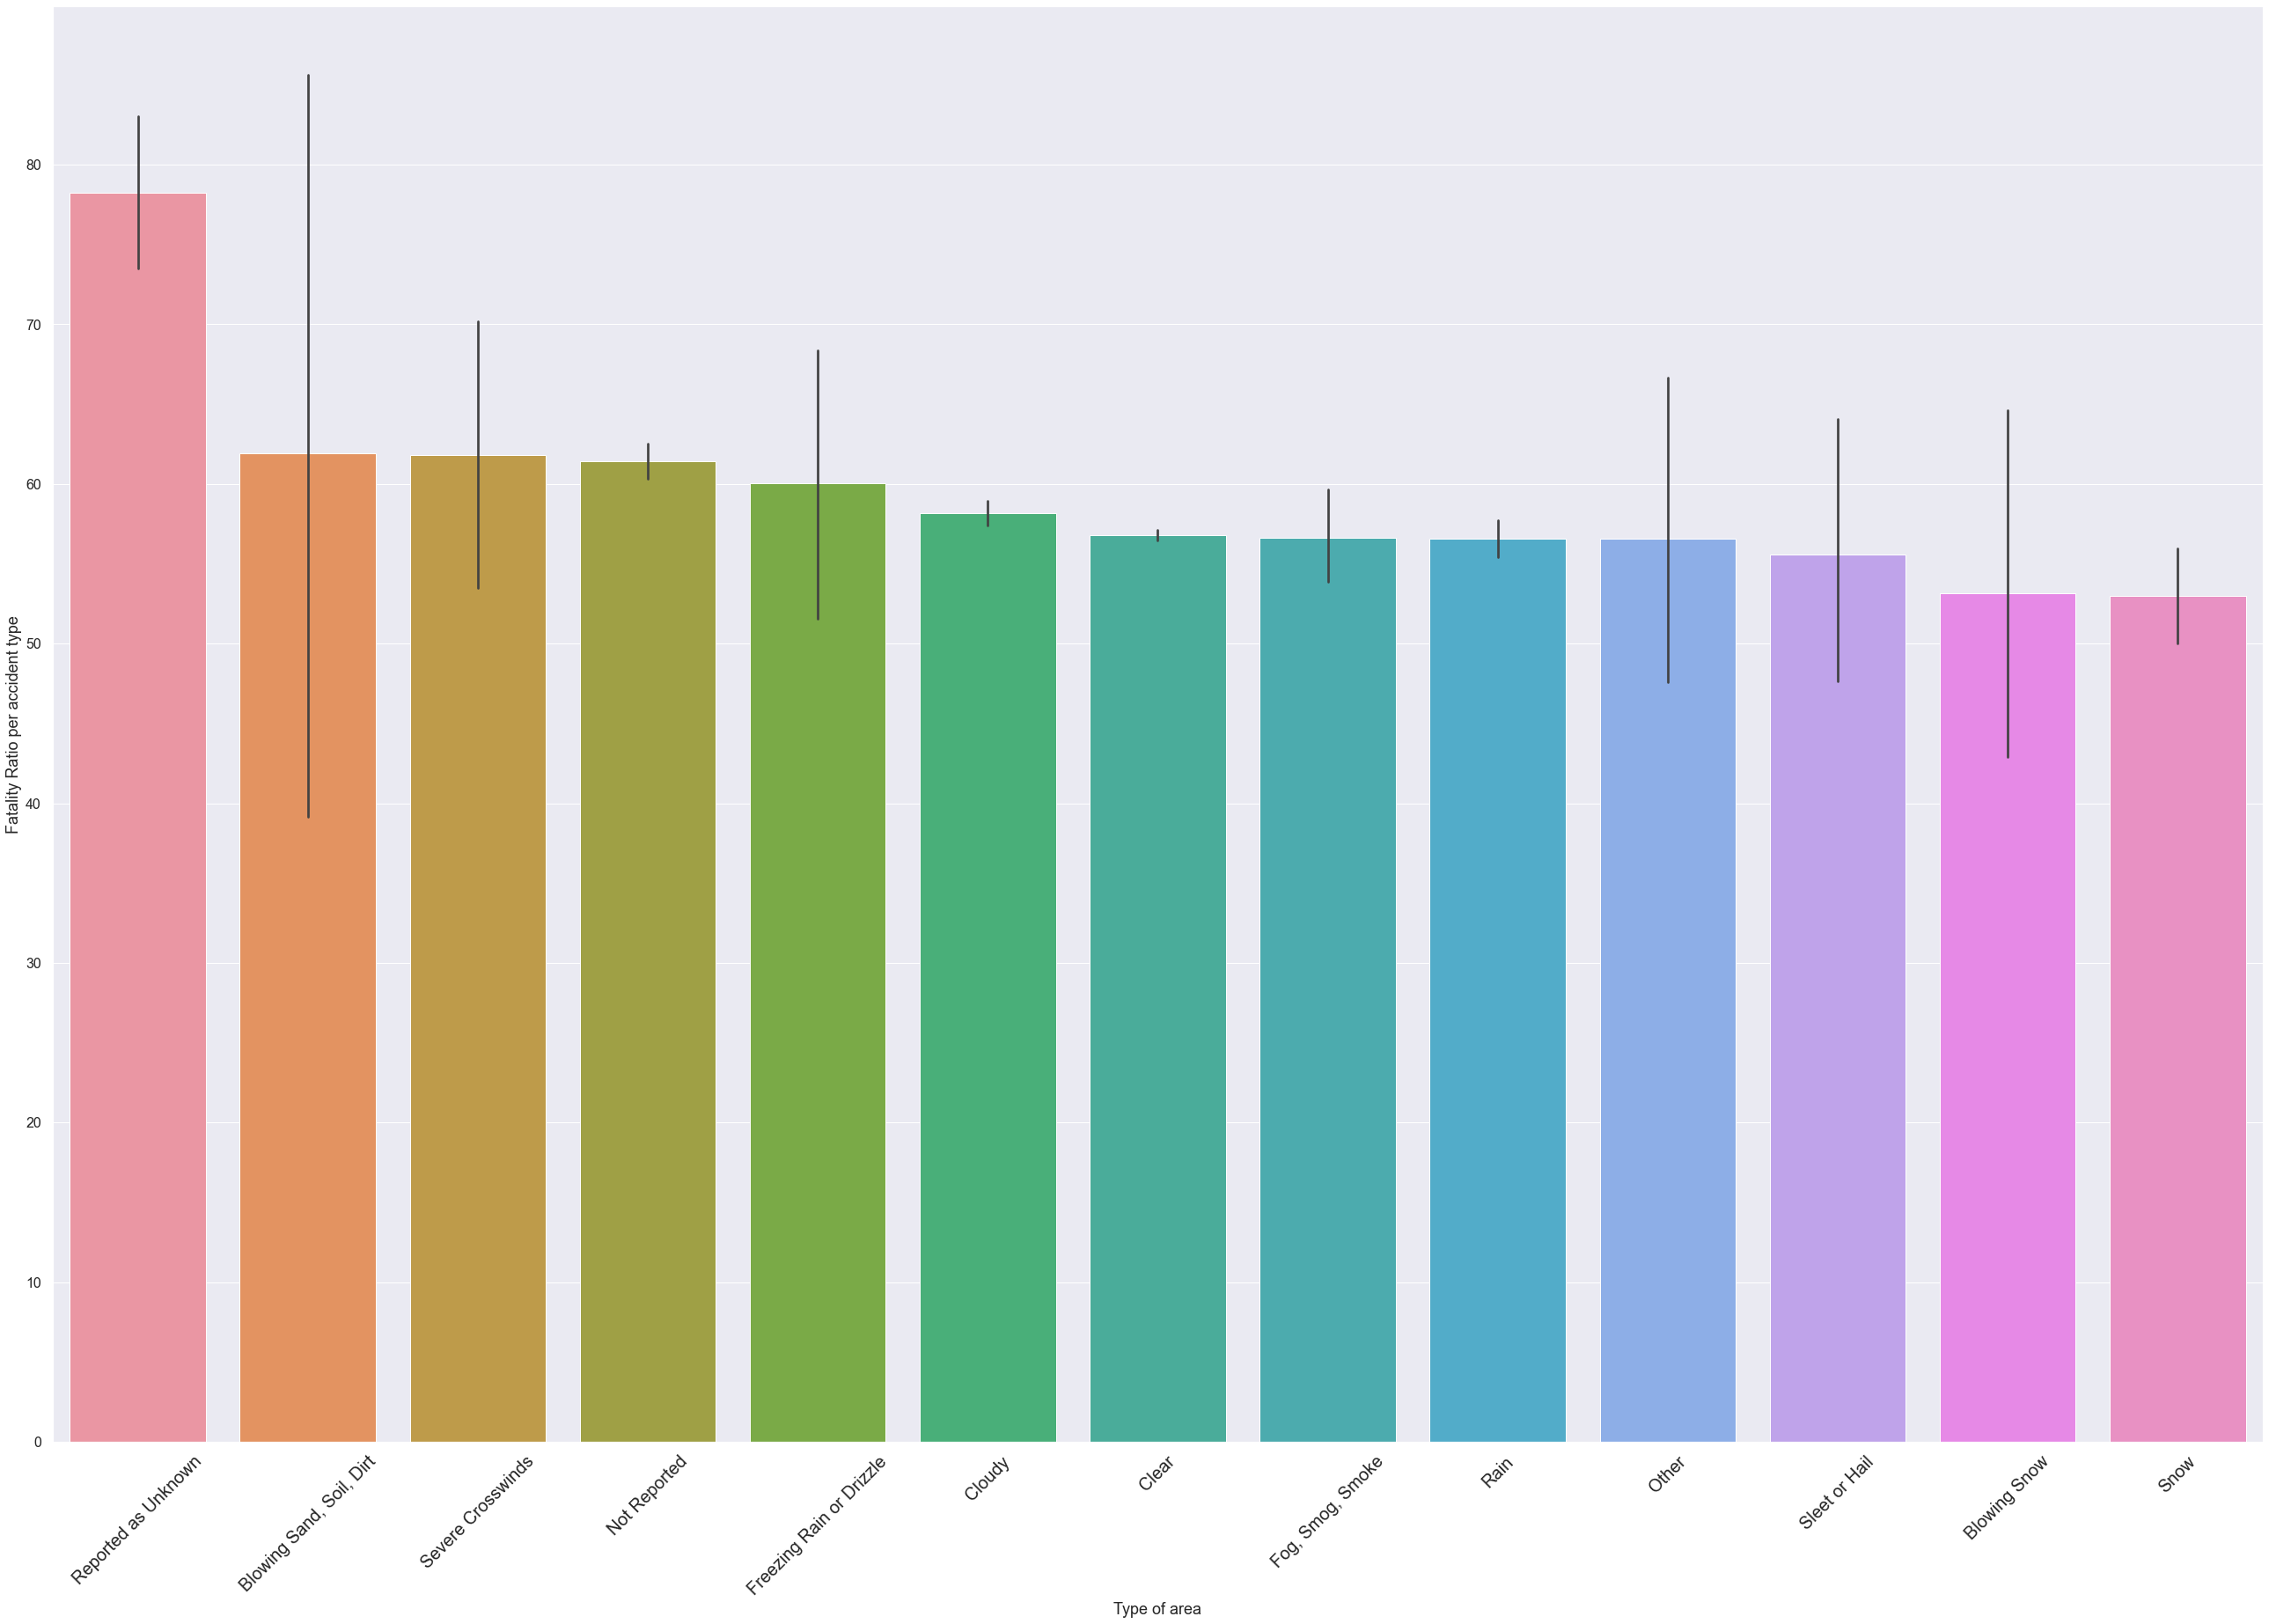

In [149]:
#Here are the difference between number of fatalities in different weather
result = total.groupby(['WEATHERNAME'])['F_RATIO'].aggregate(np.mean).reset_index().sort_values('F_RATIO', ascending=False)
fig = sns.barplot(x=total['WEATHERNAME'], y=total['F_RATIO'], order=result['WEATHERNAME'])
plt.xlabel('Type of area', fontsize=18)
plt.ylabel('Fatality Ratio per accident type', fontsize=18)
plt.xticks(rotation = 45, fontsize=20)
plt.yticks(fontsize=16)
sns.set(rc = {'figure.figsize':(25,20)})
plt.show;
plt.savefig('../reports/figures/F_Ratio for Weather Types')

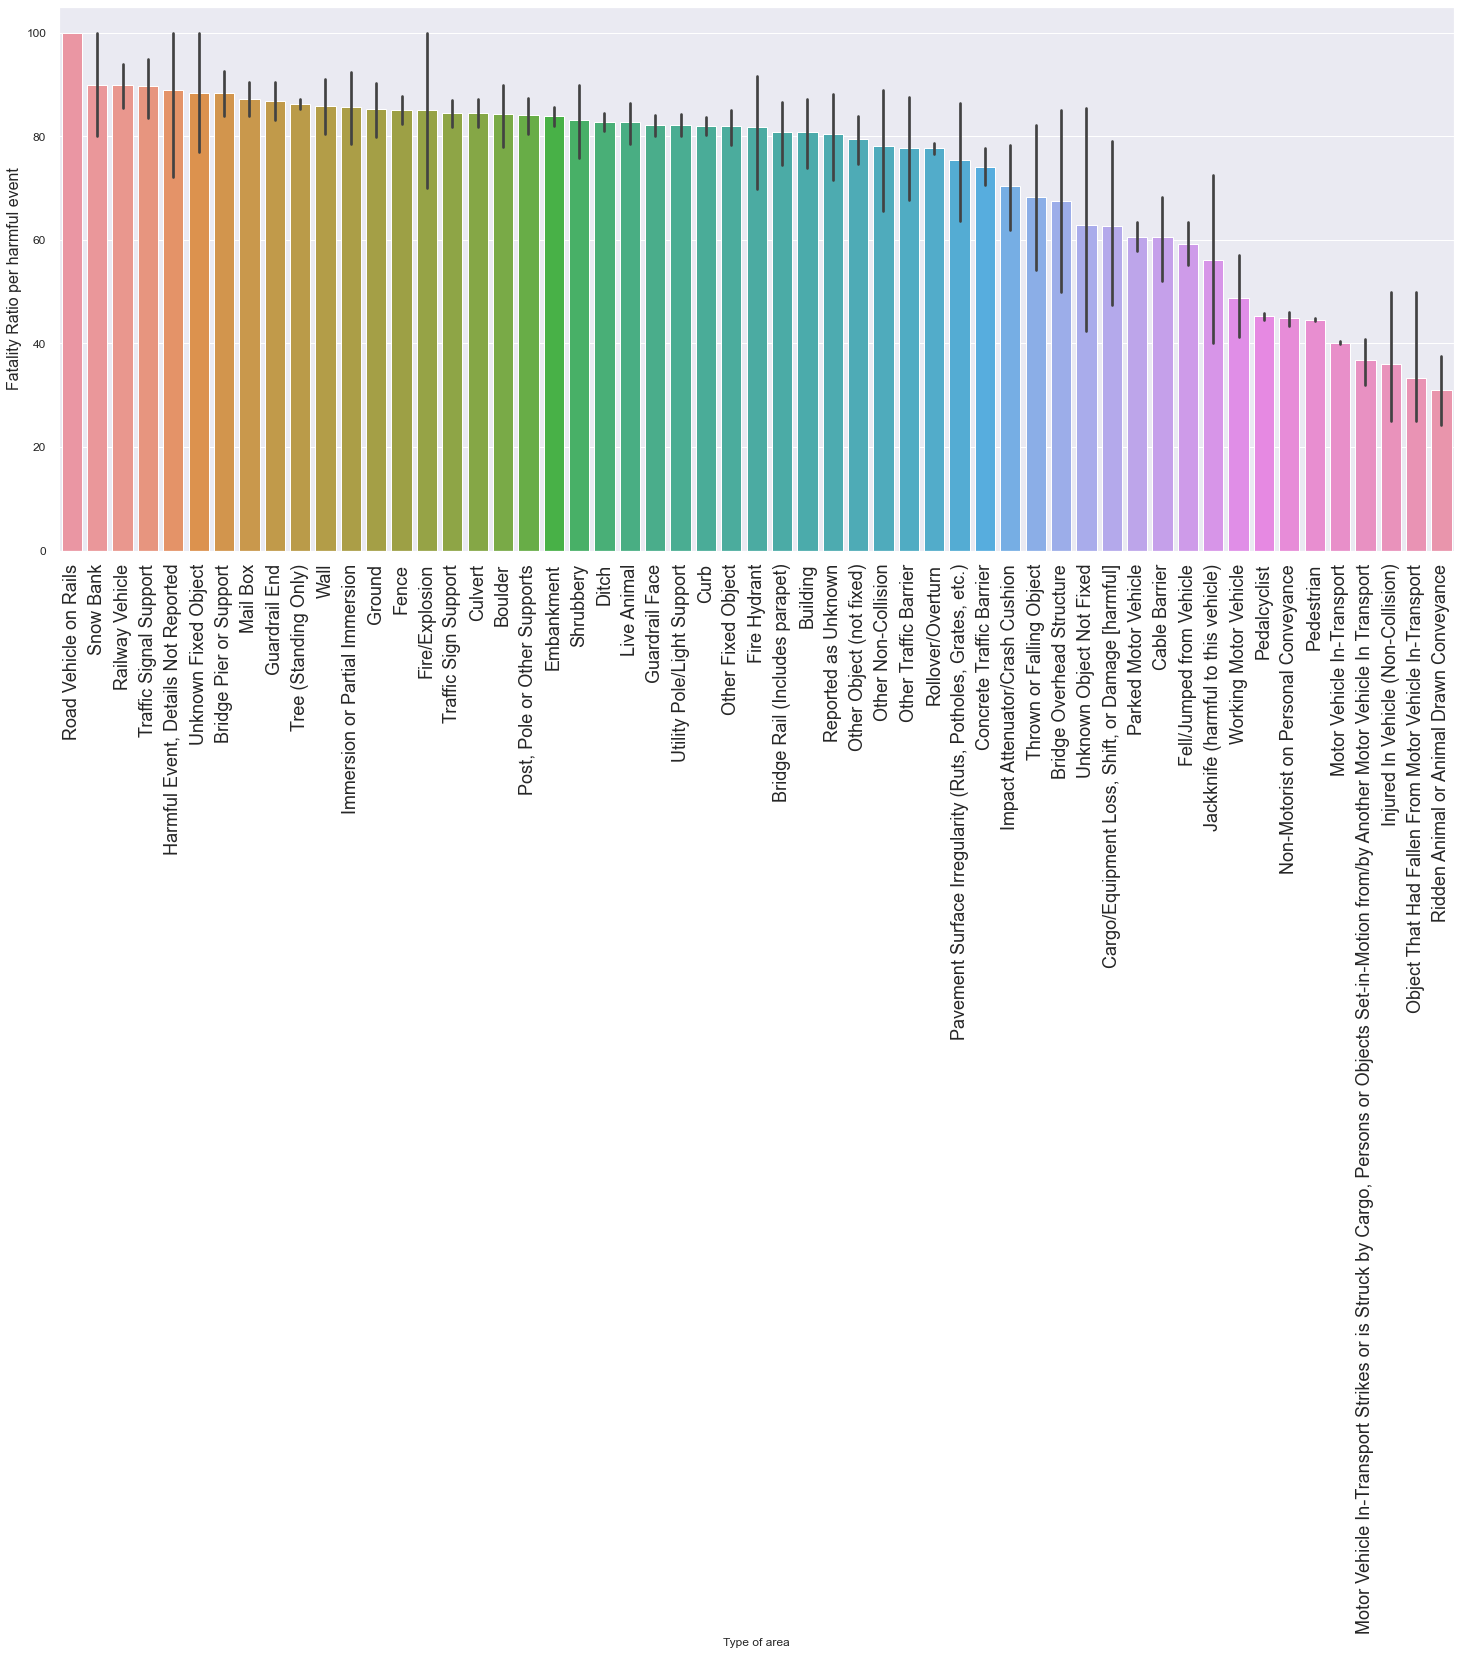

In [148]:
#Here is the F_Ratio for Harmful events; clearly sizeable variability here; Interesting events for high F_Ratios
result = total.groupby(['HARM_EVNAME'])['F_RATIO'].aggregate(np.mean).reset_index().sort_values('F_RATIO', ascending=False)
fig = sns.barplot(x=total['HARM_EVNAME'], y=total['F_RATIO'], order=result['HARM_EVNAME'])
plt.xlabel('Type of area')
plt.ylabel('Fatality Ratio per harmful event', fontsize=16)
plt.xticks(rotation = 90, fontsize=18)
plt.yticks(fontsize=12)
sns.set(rc = {'figure.figsize':(45,30)})
plt.show;
plt.savefig('../reports/figures/F_Ratio for Harmful Events')


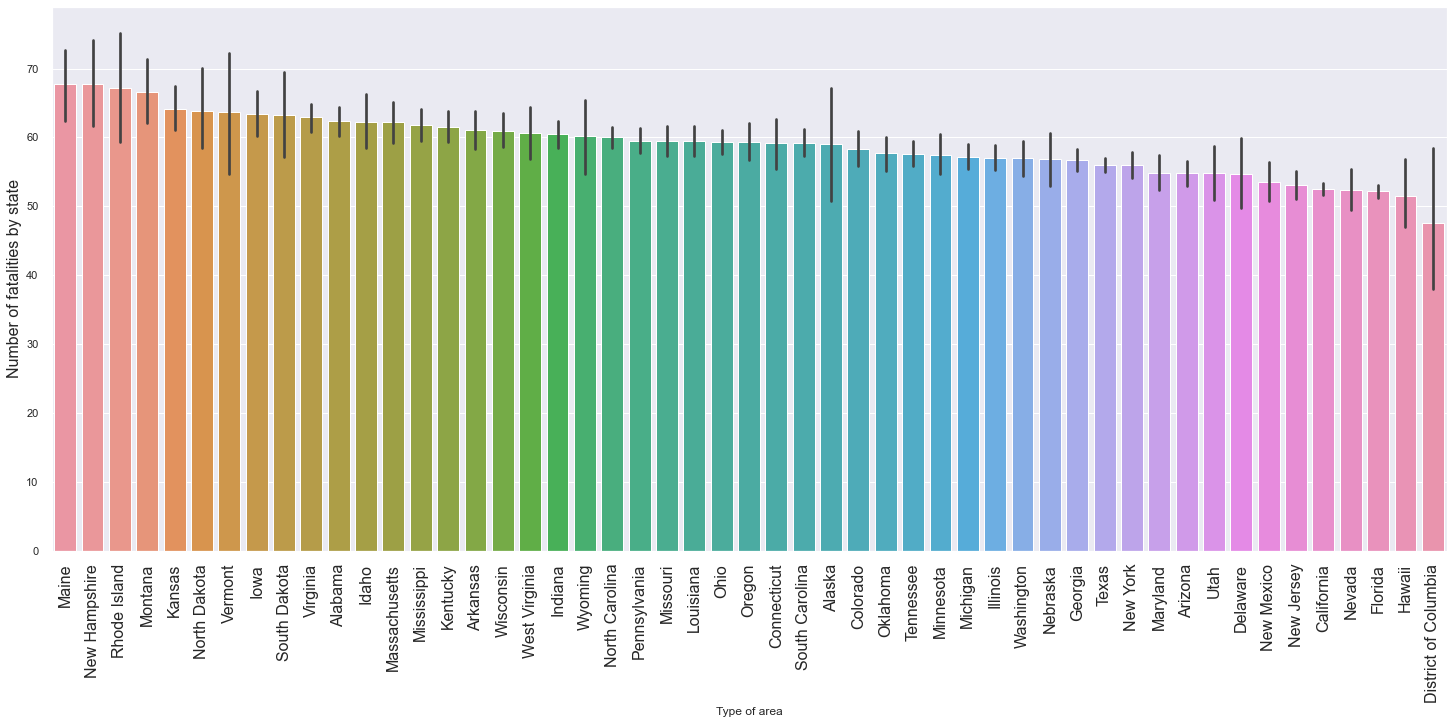

In [147]:
#Here is the F_Ratio for state name; clearly sizeable variability here also; worth keeping
result = total.groupby(['STATENAME'])['F_RATIO'].aggregate(np.mean).reset_index().sort_values('F_RATIO', ascending=False)
fig = sns.barplot(x=total['STATENAME'], y=total['F_RATIO'], order=result['STATENAME'])
plt.xlabel('Type of area')
plt.ylabel('Number of fatalities by state', fontsize=16)
plt.xticks(rotation = 90, fontsize=16)
sns.set(rc = {'figure.figsize':(25,10)})
plt.show;
plt.savefig('../reports/figures/F_Ratio for States')

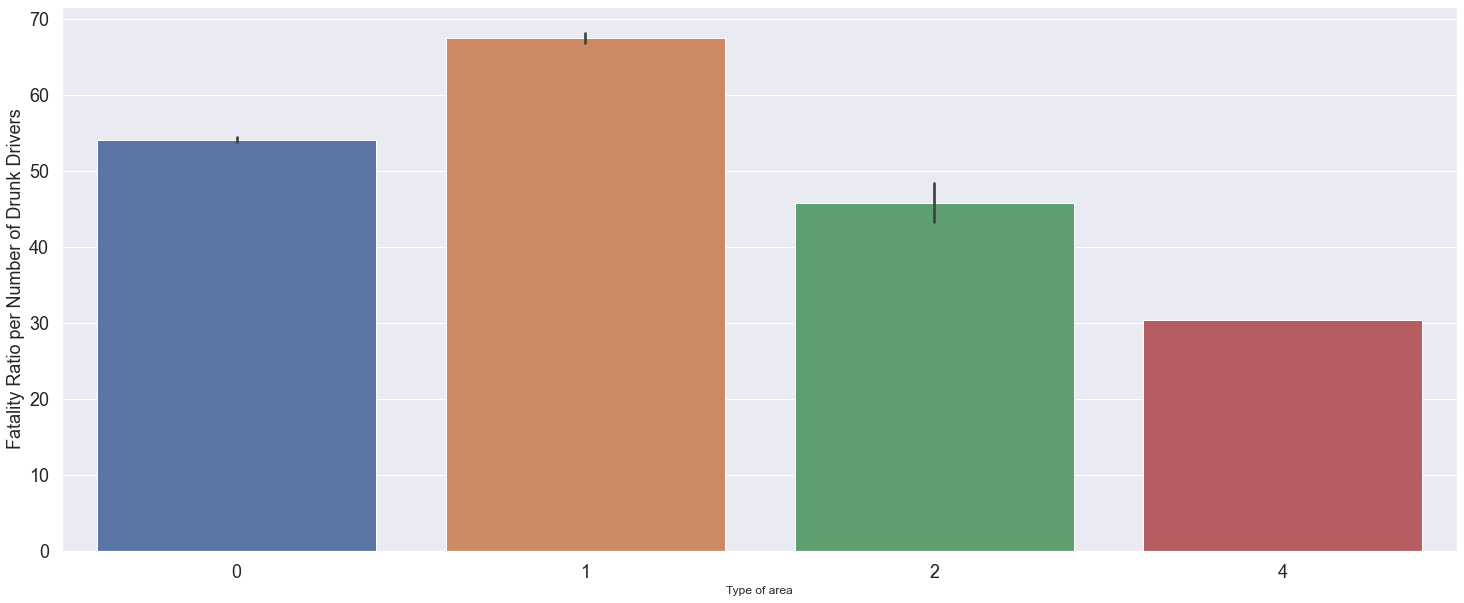

In [146]:
#Here is the F_Ratio for drunk driver; clearly sizeable variability here also; worth keeping
fig = sns.barplot(x=total['DRUNK_DR'], y=total['F_RATIO'], )
plt.xlabel('Type of area')
plt.ylabel('Fatality Ratio per Number of Drunk Drivers', fontsize=18)
plt.xticks(rotation = 0, fontsize=18)
plt.yticks(fontsize=18)
sns.set(rc = {'figure.figsize':(25,10)})
plt.savefig('../reports/figures/F_Ratio for Number of Drunk Drivers')
plt.show;

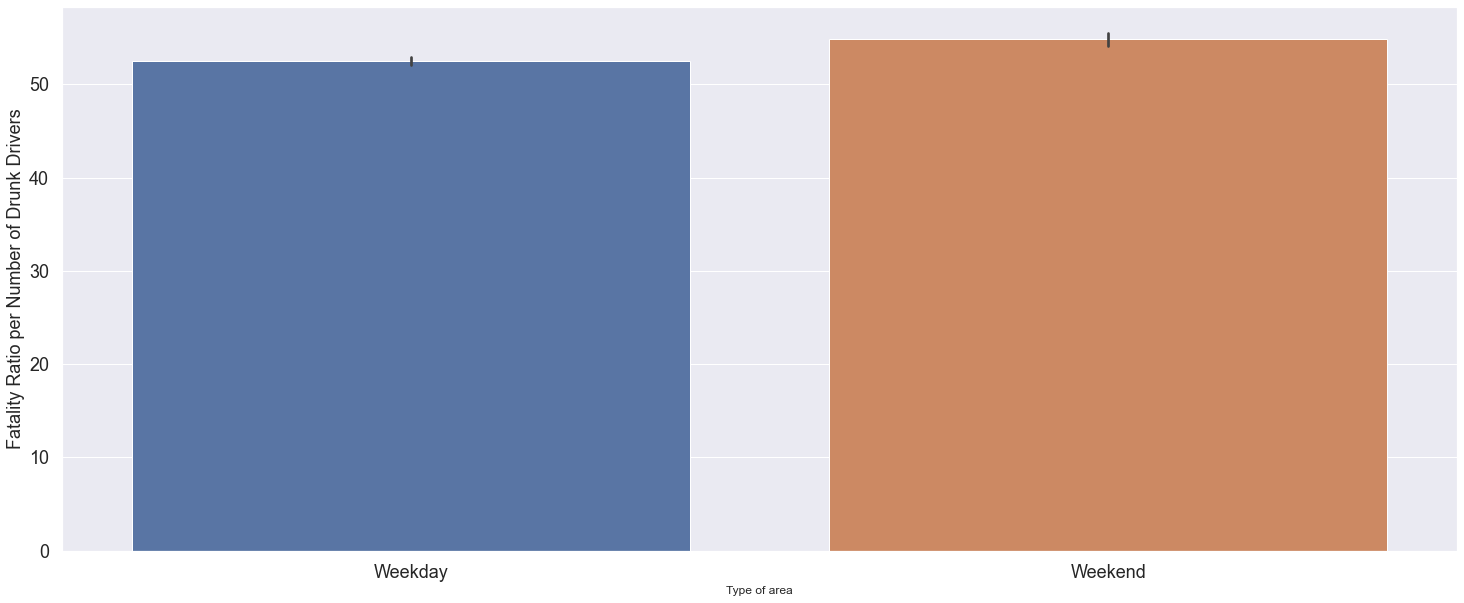

In [145]:
#Here is the F_Ratio for drunk driver; RURAL AND URBAN DON'T SHOW DIFFERENCES
fig = sns.barplot(x=urban['WEEK_END'], y=urban['F_RATIO'], )
plt.xlabel('Type of area')
plt.ylabel('Fatality Ratio per Number of Drunk Drivers', fontsize=18)
plt.xticks(rotation = 0, fontsize=18)
plt.yticks(fontsize=18)
sns.set(rc = {'figure.figsize':(25,10)})
plt.savefig('../reports/figures/F_Ratio for URBAN Weekend')
plt.show;

FileNotFoundError: [Errno 2] No such file or directory: '../figures/F_Ratio for Region.png'

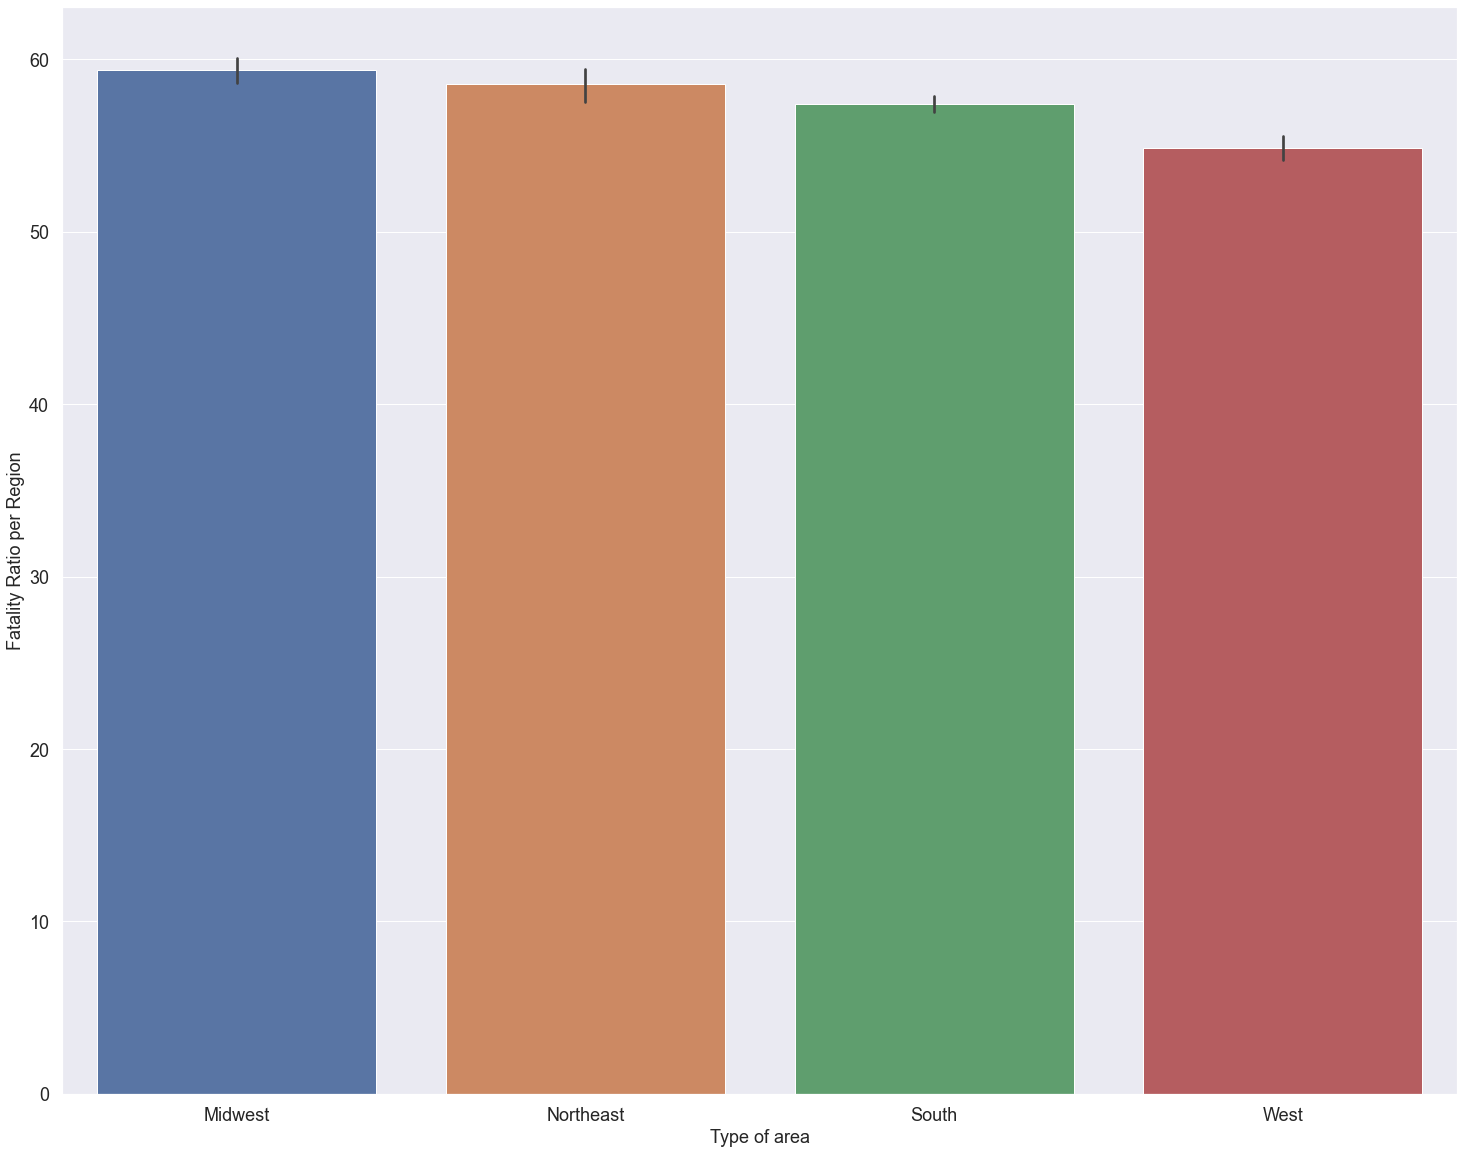

In [144]:
#Here is the F_Ratio for Region; clearly sizeable variability here also; worth keeping
fig = sns.barplot(x=total['REGION'], y=total['F_RATIO'], order=['Midwest', 'Northeast', 'South', 'West'] )
plt.xlabel('Type of area', fontsize=18)
plt.ylabel('Fatality Ratio per Region', fontsize=18)
plt.xticks(rotation = 0, fontsize=18)
plt.yticks(fontsize=18)
sns.set(rc = {'figure.figsize':(25,10)})
plt.savefig('../figures/F_Ratio for Region')
plt.show;

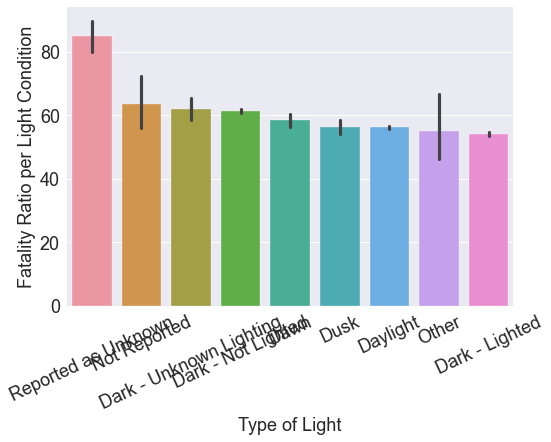

In [143]:
#Here is the F_Ratio for Region; Somewhat surprising that the Dark types are not much higher than daylight
result = total.groupby(['LGT_CONDNAME'])['F_RATIO'].aggregate(np.mean).reset_index().sort_values('F_RATIO', ascending=False)
fig = sns.barplot(x=total['LGT_CONDNAME'], y=total['F_RATIO'], order=result['LGT_CONDNAME'] )
plt.xlabel('Type of Light', fontsize=18)
plt.ylabel('Fatality Ratio per Light Condition', fontsize=18)
plt.xticks(rotation = 25, fontsize=18)
plt.yticks(fontsize=18)
sns.set(rc = {'figure.figsize':(25,20)})
plt.savefig('../reports/figures/F_Ratio for Light Condition')
plt.show;

In [ ]:
total.columns

<a id="id6"></a>

## General Conclusions

Overall, the differences are small when there are differences based on just the number of fatalities. It is clear that the Fatality Ratio (F_RATIO) is a better measure because it shows variability. The other measures, such as Day/Night Average and Weekend Average, also are not helpful. Perhaps decision trees or logistic regression should be used. Number of drunk drivers, weather conditions, and Day/Night appear to be the leading variables at this point. Rural and urban differences do not appear to be sizeable enough to justify testing them as separate datasets, but the factor of Rural vs. Urban will be kept for the total dataset.

<a id="id7"></a>

## Saving the Data

In [ ]:
total.to_csv('../data/processed/total.csv', index=False)